# <center>PRÁCTICA 2: APRENDIZAJE SUPERVISADO (DengAI)<center>

**Nombre y apellidos:** Roddy Steeven Zamora Rodríguez

**Usuario VIU:** rzamorar

---
# Resumen
---

El siguiente trabajo describe las diferentes fases para encontrar un modelo de aprendizaje supervisado optimo que tenga como fin predecir las cantidades de personas contagiadas de dengue en 2 ciudades a partir de datos climáticos a lo largo de la recolección de datos a través de los años.

Para medir los algoritmos se usa el MAE de manera local a través de un dataSet de validación y externamente en la  competición de DengAI por medio de su plataforma, la cual nos arrojara el score de las predicciones de los modelos respectivos.

En este caso el algoritmo que mejor resultado dio fue el BaggingRegresor.


---
# Inicialización
---

In [ ]:
# Imports generales
import pandas as pd
import io
from google.colab import files
import numpy as np
import time

seed = 42  # Semilla aleatoria arbitraria y constante a incluir en los algoritmos estocásticos para que los experimentos sean siempre reproducibles por el profesor.
# OJO: En los experimentos estocásticos que requieran varias iteraciones con distintas semillas, podéis incorporarla como seed+1, seed+2, etc.

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)

    return df

def download_predictions(test, pred_total_cases):
  file_name = "practica2_pred_" + time.strftime("%Y") + time.strftime("%m") + time.strftime("%d") + time.strftime("%H") + time.strftime("%M") + time.strftime("%S") + ".csv"
  predictions = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 'total_cases': pred_total_cases})
  with open(file_name, 'w') as f:
    predictions.to_csv(f, index = False)
  files.download(file_name)
  print("Downloaded " + file_name)

In [ ]:
# Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv)
train_feat = upload_files()
print(train_feat.shape)
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes
(1456, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
# Subir la variable objetivo total_cases del conjunto de entrenamiento (dengue_labels_train.csv)
train_labels = upload_files()

# Unificar el conjunto de entrenamiento (características + variable objetivo)
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
print(train.shape)
train.head()

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes
(1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [ ]:
# Subir el conjunto de test sin variable objetivo (dengue_features_test.csv)
test = upload_files()
print(test.shape)
test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes
(416, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [ ]:
testLabels = test[['city', 'year', 'weekofyear']]

---
# Reexploración
---

El dataset dengue_features_train.csv tiene datos sobre el contagio de Dengue en dos ciudades San Juan (Puerto Rico) e Iquitos (Perú). El cual contiene variables relacionadas con el clima y el ambiente, que sirven para modelar la propagación del dengue a lo largo del tiempo.

Para que nuestro analisis sea mejor es necesario entender las caracteristicas del DataSet y su respectivo significado.

Para ello imprimimos las columnas del DataSet y se averigua la información que aporta cada una de ellas.

In [ ]:
train.dtypes

,0
city,object
year,int64
weekofyear,int64
week_start_date,object
ndvi_ne,float64
ndvi_nw,float64
ndvi_se,float64
ndvi_sw,float64
precipitation_amt_mm,float64
reanalysis_air_temp_k,float64


**Indicadores de ciudad y fecha**

* city: Abreviación de la ciudad 'sj' para San Juan y 'iq' para Iquitos
* week_start_date : Fecha dada en el formato yyyy-mm-dd


**Mediciones diarias de la estación meteorológica de datos climáticos GHCN NOAA**

* station_max_temp_c: Temperatura máxima (grados celcius)
* station_min_temp_c: Temperatura mínima (grados celcius)
* station_avg_temp_c: Temperatura promedio (grados celcius)
* station_precip_mm: Precipitación total   (milimetros)
* station_diur_temp_rng_c: Rango de temperatura diurna (grados celcius)


**Mediciones de precipitación por el satélite PERSIANN (escala de 0,25x0,25 grados)**

* precipitation_amt_mm: Precipitación total (milimetros)

**Mediciones de reanálisis del sistema de pronóstico climático NCEP NOAA (escala de 0,5x0,5 grados)**

* reanalysis_sat_precip_amt_mm: Precipitación total estimada por satelite (milimetros)
* reanalysis_dew_point_temp_k: Temperatura media del punto de rocío (grados Kelvin)
* reanalysis_air_temp_k: Temperatura media del aire (grados Kelvin)
* reanalysis_relative_humidity_percent: Humedad relativa media (porcentaje %)
* reanalysis_specific_humidity_g_per_kg: Humedad específica media reanalizada, medida en gramos de vapor de agua por kilogramo de aire seco (g/kg)
* reanalysis_precip_amt_kg_per_m2: Precipitación total reanalizada, medida en kilogramos por metro cuadrado (kg/m²)
* reanalysis_max_air_temp_k: Temperatura máxima del aire (grados Kelvin)
* reanalysis_min_air_temp_k: Temperatura mínima del aire (grados Kelvin)
* reanalysis_avg_temp_k: Temperatura media del aire      (grados Kelvin)
* reanalysis_tdtr_k: Rango de temperatura diurna         (grados Kelvin)

**Mediciones del índice de vegetación de diferencia normalizada CDR NOAA (escala de 0,5x0,5 grados)** (donde valores cercanos a 1 indican vegetación densa y saludable)
* ndvi_se: Píxel al sureste del centroide de la ciudad
* ndvi_sw: Píxel al suroeste del centroide de la ciudad
* ndvi_ne: Píxel al noreste del centroide de la ciudad
* ndvi_nw: Píxel al noroeste del centroide de la ciudad

**Escala de tiempo**
* year: Año en el que se registró cada observación
* weekofyear: Semana del año en que se tomó la observación

**Objetivo**
* total_cases: Número totales de casos de dengue.


Para mayor informacion visitar: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/




In [ ]:
#Guardamos el dataSet original para no perder esa información
trainPreProcesing = train
#tamaño del dataSet
train.shape

(1456, 25)

In [ ]:
testOriginal = test

In [ ]:
# EJEMPLO: Eliminar variable week_start_date por ser de tipo cadena de texto sin formato
train.drop("week_start_date", axis = 1, inplace = True)
test= test.drop("week_start_date", axis = 1)

In [ ]:
#obtenemos las estadisticas descriptivas de las variables numericas  dejando de lado los registros del año en donde se tomo la muestra y la ciudad
trainFiltrado = train.drop(columns=['year', 'weekofyear','city'])
trainFiltrado.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000
mean,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,303.427109,295.719156,...,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137
std,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,3.234601,2.565364,...,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,...,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,301.000000,293.900000,...,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000
50%,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,302.400000,296.200000,...,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000
75%,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,305.500000,297.900000,...,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,...,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000


Vemos que muchas columnas en su count no llegan a los 1456 que es el tamaño del DataFrame, lo cual ya nos da un primer vistazo que existen valores nulos. Hay algunas variables (reanalysis_air_temp_k  reanalysis_avg_temp_k reanalysis_dew_point_temp_k) en donde su media (mean) y la mediana (50%) presentan valores muy parecidos por lo que es un primer indicio de que siguen una distribución simétrica. Estas distribuciones se verán mejor en los histogramas.

Nos enfocamos en las estadísticas de la variable objetivo para entender un poco más su comportamiento.

In [ ]:
train['total_cases'].describe()

,total_cases
count,1456.000000
mean,24.675137
std,43.596000
min,0.000000
25%,5.000000
50%,12.000000
75%,28.000000
max,461.000000


Se puede apreciar que un caso extremo de casos puede llegar a 461; no existe una distribución simétrica debido a la diferencia entre la media y la mediana (50%). Existe una gran diferencia entre el máximo y el Q3, por lo que puede ser un indicio de outliers por la parte superior.

La desviación estándar alta de 43.6, indica una gran dispersión por lo que los casos de dengue pueden variar considerablemente entre períodos.


In [ ]:
# EJEMPLO: Contar valores perdidos
pd.isnull(train).sum()

,0
city,0
year,0
weekofyear,0
ndvi_ne,194
ndvi_nw,52
ndvi_se,22
ndvi_sw,22
precipitation_amt_mm,13
reanalysis_air_temp_k,10
reanalysis_avg_temp_k,10


In [ ]:
pd.isnull(test).sum()

,0
city,0
year,0
weekofyear,0
ndvi_ne,43
ndvi_nw,11
ndvi_se,1
ndvi_sw,1
precipitation_amt_mm,2
reanalysis_air_temp_k,2
reanalysis_avg_temp_k,2


Antes de llenar los valores nulos mediante el método ffill es crucial que los datos estén ordenados de manera que el relleno hacia adelante tenga sentido lógico y que no se mezclen datos de diferentes ciudades, años o semanas.

In [ ]:
#El dataSet si esta ordenado por lo que esto no es necesario

# Ordenar el DataFrame por 'city', 'year', y 'weekofyear'
#Primero por ciudad y DESC para mantener la misma forma del csv (primero va sj)
#rain.sort_values(by=['city'] ,ascending=False, inplace=True)
#luego ya nos aseguramos que este ordenado por año y semana
#rain.sort_values(by=[ 'year', 'weekofyear'], inplace=True)
#rain.head()

In [ ]:
#train.tail()

In [ ]:
## Ordenar el DataFrame por 'city', 'year', y 'weekofyear'
##Primero por ciudad y DESC para mantener la misma forma del csv (primero va sj)
#test.sort_values(by=['city'] ,ascending=False, inplace=True)
##luego ya nos aseguramos que este ordenado por año y semana
#test.sort_values(by=[ 'year', 'weekofyear'], inplace=True)
#test.head()

Con la data mas limpia se procede a realizar el llenado de nulos.

In [ ]:
# EJEMPLO: Completar valores perdidos con método ffill
# Alternativa: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
train.fillna(method='ffill', inplace=True)
pd.isnull(train).any()

<ipython-input-14-a1952bf7d281>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill', inplace=True)


,0
city,False
year,False
weekofyear,False
ndvi_ne,False
ndvi_nw,False
ndvi_se,False
ndvi_sw,False
precipitation_amt_mm,False
reanalysis_air_temp_k,False
reanalysis_avg_temp_k,False


In [ ]:
# EJEMPLO: Completar valores perdidos con método ffill
# Alternativa: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
test.fillna(method='ffill', inplace=True)
pd.isnull(test).any()

<ipython-input-15-5076ee70924d>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill', inplace=True)


,0
city,False
year,False
weekofyear,False
ndvi_ne,False
ndvi_nw,False
ndvi_se,False
ndvi_sw,False
precipitation_amt_mm,False
reanalysis_air_temp_k,False
reanalysis_avg_temp_k,False


Se crea histogramas para visualizar que distribución siguen las variables numéricas

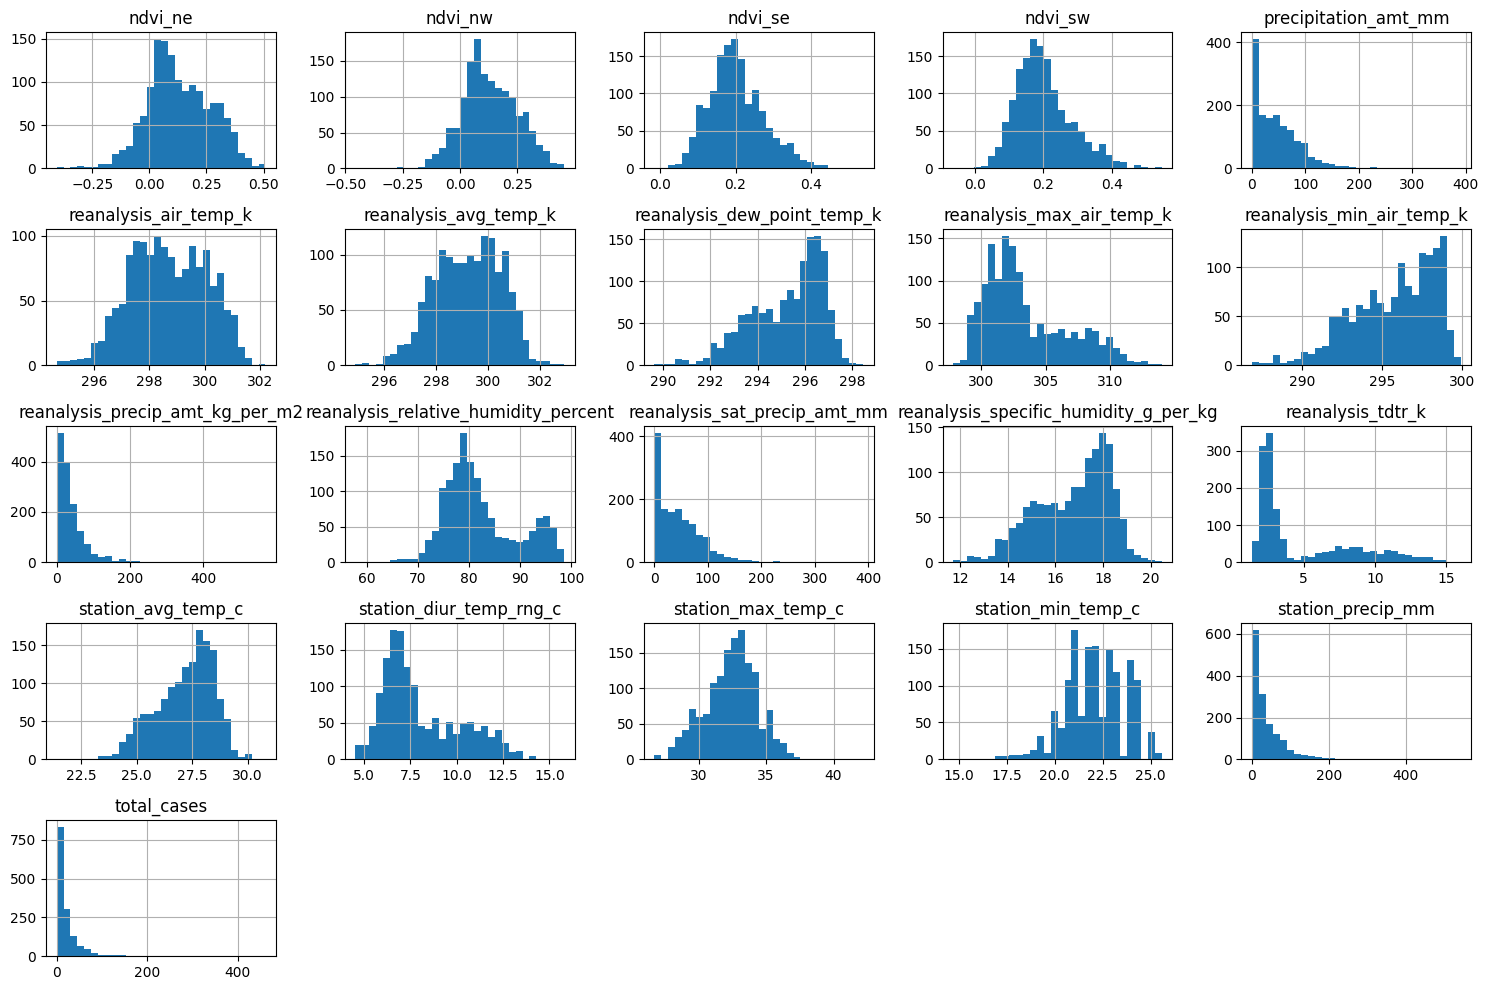

In [ ]:
#una vez importado se lo ubicara arriba
import matplotlib.pyplot as plt
# Histogramas de las variables numéricas continuas
excluded_cols = ['year', 'weekofyear']
train.drop(excluded_cols, axis=1).hist(bins=30, figsize=(15,10))
plt.tight_layout()
plt.show()

#Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html

Algunas variables en su histograma muestran una especie de forma de campana característica de la distribución normal como ndvi_nw, ndvi_se, ndvi_sw, reanalysis_avg_temp_k y station_avg_temp_c.

Las variables de precipitación como precipitation_amt_mm, reanalysis_precip_amt_kg_per_m2, reanalysis_sat_precip_amt_mm y station_precip_mm muestran un patrón muy similar con picos altos en los primeros registros y una caída progresiva de sus valores, lo cual puede inducir a que dichas variables aportan la misma información y que mayoritariamente no hay precipitaciones.

En reanalysis_relative_humidity_percent se puede observar dos grupos que se asemejan cada uno a una campana de Gauss, lo que sugiere que está compuesto por subgrupos de diferentes características.

Respecto al número de casos se puede ver un pico en los primeros puntos del grafico lo cual podría ser un indicio de algún outlier.

**Visualizaciones graficas de datos a traves del tiempo**

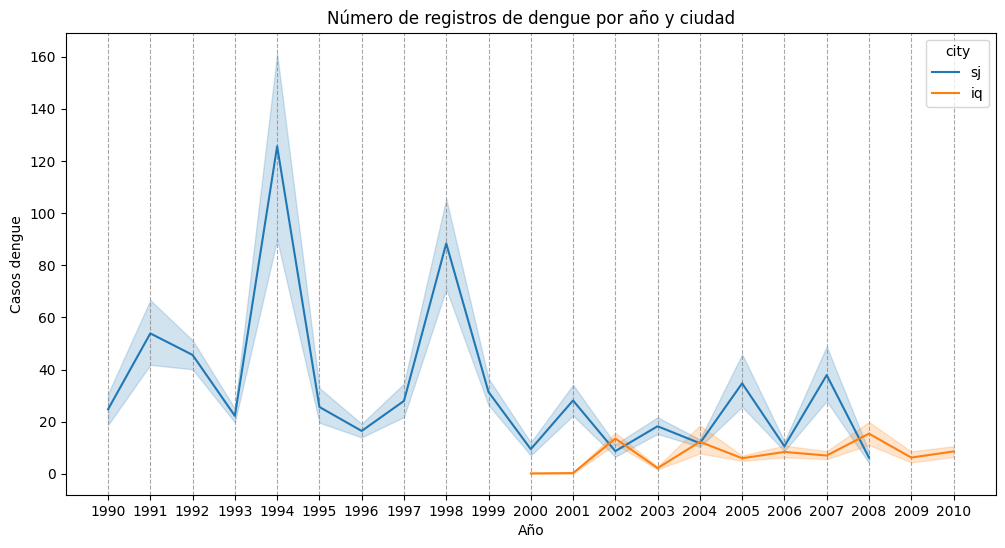

In [ ]:
import seaborn as sns
# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Gráfico de líneas
sns.lineplot(x='year', y='total_cases', hue='city', data=train)


# Título y etiquetas
plt.title('Número de registros de dengue por año y ciudad')
plt.xlabel('Año')
plt.ylabel('Casos dengue')

#grid
year_min = train['year'].min()
year_max = train['year'].max()
plt.xticks(range(year_min, year_max + 1, 1))

plt.grid(axis='x', linestyle='--', color='gray', alpha=0.7)

# Mostrar el gráfico
plt.show()

#References:
#https://seaborn.pydata.org/generated/seaborn.lineplot.html
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html

Se puede ver que en San Juan existe más cantidad de dengue que Iquitos, en donde en San Juan se tiene picos muy altos de dengue en 1994 y 1998, mostrando una tendencia de sierra con altas subidas y bajadas a lo largo de los años, regularizándose un poco a partir del 2000.

En Iquitos también existe una forma de sierra, pero con aumentos y disminuciones más controladas y no tendiendo valores tan altos, manejándose desde 0 hasta aproximadamente 20 casos, por lo que es una ciudad donde esta enfermedad está mucho más controlada.


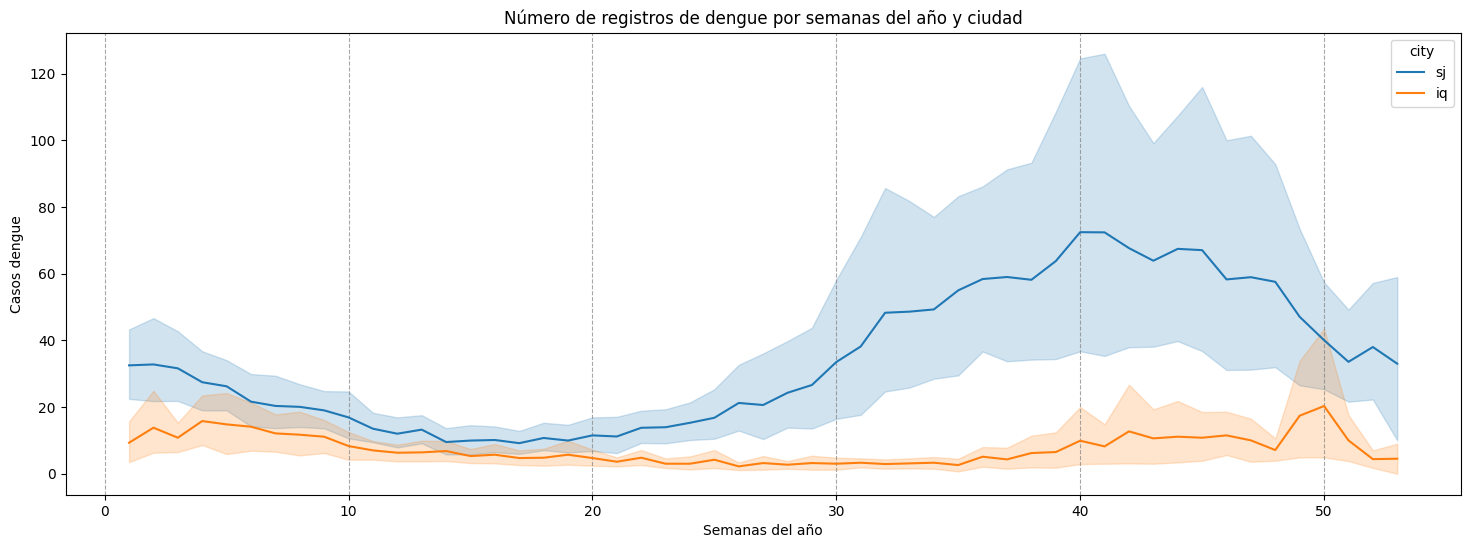

In [ ]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(18, 6))

# Gráfico de líneas
sns.lineplot(x='weekofyear', y='total_cases', hue='city', data=train)

# Título y etiquetas
plt.title('Número de registros de dengue por semanas del año y ciudad')
plt.xlabel('Semanas del año')
plt.ylabel('Casos dengue')

plt.grid(axis='x', linestyle='--', color='gray', alpha=0.7)

# Mostrar el gráfico
plt.show()
#References:
#https://seaborn.pydata.org/generated/seaborn.lineplot.html

Para San Juan las semanas con mayor índice de crecimiento de dengue se da aproximadamente desde la semana 30 hasta la 40, y a partir de ahí empieza a decrecer lentamente pero aun manteniendo valores altos.

Para Iquitos no se ven fluctuaciones tan marcadas y en general los valores no superan a los 30 casos.


**Tratamientos de outliers**

Debido a que es el mismo dataSet de train que la actividad 1 se hara el mismo tratamiento de outliers, por lo que nos concetraremos en aquellas variables en la que si se hizo este tratamiento, saltandonos la visualizacion de los otros datos.

**Posibles outliers de las variables que representan las precipitaciones.**

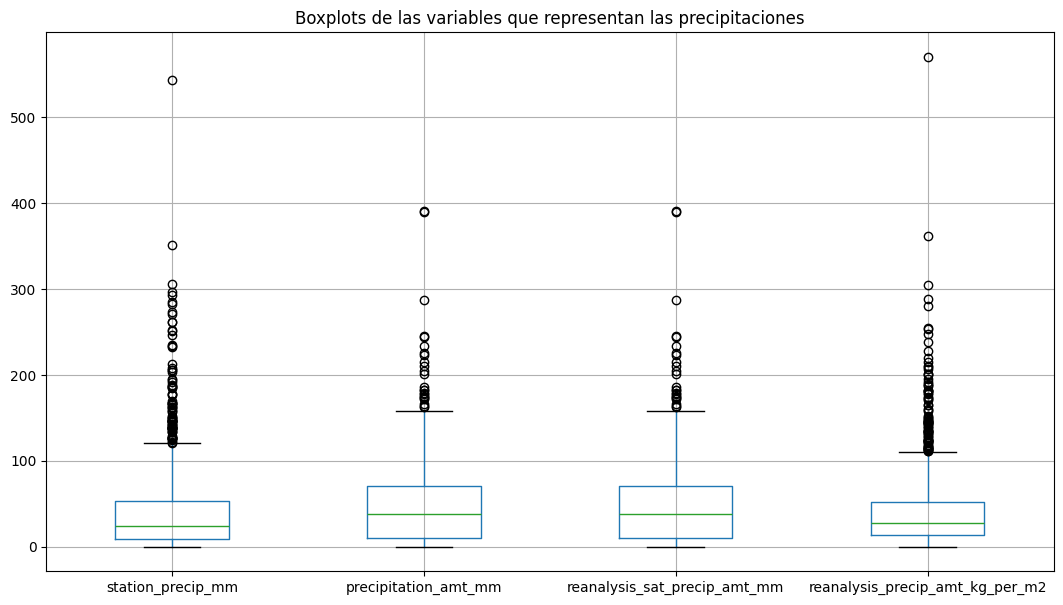

In [ ]:
plt.figure(figsize=(13,7))
train[['station_precip_mm','precipitation_amt_mm','reanalysis_sat_precip_amt_mm','reanalysis_precip_amt_kg_per_m2']].boxplot()
plt.title('Boxplots de las variables que representan las precipitaciones')
plt.show()

Los datos de las precipitaciones medidos de diferentes formas tienen características similares como su rango intercuartílico y sus outliers los cuales parecen ser un valor considerable y están todos por encima de su límite superior. Estos niveles inusualmente altos de precipitaciones pueden deberse a fenómenos naturales como el niño que se caracteriza por las presencias de muchas lluvias e inundaciones, este fenómeno suele presentarse cada 2 a 7 años por lo que la presencias de estos outlieres tan altos se podrían deber a esos años inusuales. https://cnnespanol.cnn.com/2024/02/09/que-es-nino-fenomeno-por-que-ocurre-efectos-trax#:~:text=El%20fen%C3%B3meno%20de%20El%20Ni%C3%B1o,patr%C3%B3n%20clim%C3%A1tico%20de%20La%20Ni%C3%B1a.


Para estos outliers se optará por eliminar aquellos que no estén muy apegados a los limites superiores e inferiores, para esto se aumenta a 2 el factor IQR y a partir de ahí eliminar estos valores atípicos.

In [ ]:
#primero se define una función para que se pueda reutilizar
#esta función tiene el fin de eliminar los outlieres en base a la columna y un factor que se multiplicara al IQR
def eliminarOutlieres(factor, columna):
    # Verificar si la columna existe y no es de tipo objeto
    if columna in train.select_dtypes(exclude=['object']).columns:
        Q1 = train[columna].quantile(0.25)
        Q3 = train[columna].quantile(0.75)
        IQR = Q3 - Q1

        # Ajustar el factor IQR
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Identificar outliers en función de los límites
        outliers = train[(train[columna] < lower_bound) | (train[columna] > upper_bound)]

        print(f"Eliminando {len(outliers)} outliers en '{columna}'.")

        # Eliminar los outliers del DataFrame original
        train.drop(outliers.index, inplace=True)

        # Verificar los datos restantes después de eliminar los outliers
        print('')
        print(f"Cantidad de registros después de eliminar outliers: {len(train)}")
    else:
        print(f"La columna '{columna}' no es válida o es de tipo object.")

#References:
#Este código fue desarrollado con la asistencia de ChatGPT de OpenAI y en base a
#https://stackoverflow.com/questions/34782063/how-to-use-pandas-filter-with-iqr


Eliminamos los outliers que esten 2*IQR mas lejos de los limites, esto para las columnas 'station_precip_mm','precipitation_amt_mm','reanalysis_sat_precip_amt_mm','reanalysis_precip_amt_kg_per_m2'

In [ ]:
eliminarOutlieres(2,'station_precip_mm')
eliminarOutlieres(2,'precipitation_amt_mm')
eliminarOutlieres(2,'reanalysis_sat_precip_amt_mm')
eliminarOutlieres(2,'reanalysis_precip_amt_kg_per_m2')

Eliminando 57 outliers en 'station_precip_mm'.

Cantidad de registros después de eliminar outliers: 1399
Eliminando 9 outliers en 'precipitation_amt_mm'.

Cantidad de registros después de eliminar outliers: 1390
Eliminando 1 outliers en 'reanalysis_sat_precip_amt_mm'.

Cantidad de registros después de eliminar outliers: 1389
Eliminando 59 outliers en 'reanalysis_precip_amt_kg_per_m2'.

Cantidad de registros después de eliminar outliers: 1330


Para cuantificar cuantos outliers hay se mostrará la cantidad de valores fuera de rango por característica y que porcentaje representa.

In [ ]:
#Primero creamos una función que imprima esos valores para poder reutilizarla

def imprimirOutlieres(df,factor):
  # Filtrar columnas que no son 'object'
  columns_to_check = df.select_dtypes(exclude=['object']).columns

  # Lista para almacenar los resultados
  outliers_summary = []

  # Iterar sobre cada columna
  for column in columns_to_check:
      Q1 = df[column].quantile(0.25)
      Q3 = df[column].quantile(0.75)
      IQR = Q3 - Q1

      # Definir límites
      lower_bound = Q1 - factor * IQR
      upper_bound = Q3 + factor * IQR

      # Identificar outliers
      outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

      # Almacenar el resultado en una lista
      outliers_summary.append({
          'column': column,
          'num_outliers': len(outliers),
          'percentage_outliers': (len(outliers) / len(df[column])) * 100
      })

  # Ordenar los resultados por número de outliers de forma descendente
  outliers_summary_sorted = sorted(outliers_summary, key=lambda x: x['num_outliers'], reverse=True)

  # Imprimir los resultados ordenados
  for summary in outliers_summary_sorted:
      print(f"\nNúmero de valores fuera de rango en '{summary['column']}': {summary['num_outliers']}")
      print(f"Porcentaje de valores fuera de rango en '{summary['column']}': {summary['percentage_outliers']:.2f} %")

#References:
#Código generado con la asistencia de ChatGPT de OpenAI


In [ ]:
# usamos la funcion con una factor IQR de 1.5 (igual que el del metodo boxplot())
imprimirOutlieres(train,1.5)


Número de valores fuera de rango en 'total_cases': 108
Porcentaje de valores fuera de rango en 'total_cases': 8.12 %

Número de valores fuera de rango en 'reanalysis_relative_humidity_percent': 79
Porcentaje de valores fuera de rango en 'reanalysis_relative_humidity_percent': 5.94 %

Número de valores fuera de rango en 'station_precip_mm': 59
Porcentaje de valores fuera de rango en 'station_precip_mm': 4.44 %

Número de valores fuera de rango en 'reanalysis_precip_amt_kg_per_m2': 48
Porcentaje de valores fuera de rango en 'reanalysis_precip_amt_kg_per_m2': 3.61 %

Número de valores fuera de rango en 'ndvi_sw': 36
Porcentaje de valores fuera de rango en 'ndvi_sw': 2.71 %

Número de valores fuera de rango en 'ndvi_se': 23
Porcentaje de valores fuera de rango en 'ndvi_se': 1.73 %

Número de valores fuera de rango en 'station_min_temp_c': 16
Porcentaje de valores fuera de rango en 'station_min_temp_c': 1.20 %

Número de valores fuera de rango en 'precipitation_amt_mm': 14
Porcentaje de va

Se logra observar que en el train a excepción de 2 variables (entre ellas la objetivo) los outliers no superan el 5%, aunque se debe tener en cuenta ya que muchos modelos son susceptibles a estos valores fuera de rango.

In [ ]:
# vemos tambien para la parte del test
imprimirOutlieres(test,1.5)


Número de valores fuera de rango en 'reanalysis_precip_amt_kg_per_m2': 26
Porcentaje de valores fuera de rango en 'reanalysis_precip_amt_kg_per_m2': 6.25 %

Número de valores fuera de rango en 'station_precip_mm': 17
Porcentaje de valores fuera de rango en 'station_precip_mm': 4.09 %

Número de valores fuera de rango en 'precipitation_amt_mm': 8
Porcentaje de valores fuera de rango en 'precipitation_amt_mm': 1.92 %

Número de valores fuera de rango en 'reanalysis_sat_precip_amt_mm': 8
Porcentaje de valores fuera de rango en 'reanalysis_sat_precip_amt_mm': 1.92 %

Número de valores fuera de rango en 'station_min_temp_c': 7
Porcentaje de valores fuera de rango en 'station_min_temp_c': 1.68 %

Número de valores fuera de rango en 'ndvi_sw': 5
Porcentaje de valores fuera de rango en 'ndvi_sw': 1.20 %

Número de valores fuera de rango en 'ndvi_se': 4
Porcentaje de valores fuera de rango en 'ndvi_se': 0.96 %

Número de valores fuera de rango en 'ndvi_ne': 1
Porcentaje de valores fuera de ran

Presenta menos valores fuera de rango que el train.

## Características

In [ ]:
# EJEMPLO: Binarizador para la variable categórica city en el conjunto de entrenamiento y test
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])

train.tail()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,city_bin
1450,iq,2010,20,0.263071,0.272500,0.258271,0.244500,1.15,297.648571,298.707143,...,1.15,14.908571,11.242857,25.633333,9.200000,34.0,20.0,2.5,6,0
1451,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,...,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5,0
1453,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,...,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1,0
1454,iq,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,...,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1,0
1455,iq,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,299.835714,...,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4,4,0


In [ ]:
#1:sj      0:iq
train.drop('city', axis=1, inplace=True)
test.drop('city', axis=1, inplace=True)
train.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,city_bin
0,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,1
1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,1
2,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,1
3,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,1
4,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,1


Es importante antes de hacer un análisis de componentes tener las unidades de las variables en un mismo sistema coherente.

Las temperaturas que están en grados Kelvin se lo pasaran a grados Celsius.

* reanalysis_air_temp_k
* reanalysis_max_air_temp_k
* reanalysis_min_air_temp_k
* reanalysis_avg_temp_k
* reanalysis_dew_point_temp_k


In [ ]:
# Convertir las columnas de Kelvin a Celsius
train['reanalysis_air_temp_k'] = train['reanalysis_air_temp_k'] - 273.15
test['reanalysis_air_temp_k'] = test['reanalysis_air_temp_k'] - 273.15

train['reanalysis_max_air_temp_k'] = train['reanalysis_max_air_temp_k'] - 273.15
test['reanalysis_max_air_temp_k'] = test['reanalysis_max_air_temp_k'] - 273.15

train['reanalysis_min_air_temp_k'] = train['reanalysis_min_air_temp_k'] - 273.15
test['reanalysis_min_air_temp_k'] = test['reanalysis_min_air_temp_k'] - 273.15

train['reanalysis_avg_temp_k'] = train['reanalysis_avg_temp_k'] - 273.15
test['reanalysis_avg_temp_k'] = test['reanalysis_avg_temp_k'] - 273.15

train['reanalysis_dew_point_temp_k'] = train['reanalysis_dew_point_temp_k'] - 273.15
test['reanalysis_dew_point_temp_k'] = test['reanalysis_dew_point_temp_k'] - 273.15

#Representa la diferencia entre la temperatura máxima y mínima del día, por lo que no es correcto transformarle
#train['reanalysis_tdtr_k'] = train['reanalysis_tdtr_k'] - 273.15
#test['reanalysis_tdtr_k'] = test['reanalysis_tdtr_k'] - 273.15

# Renombrar las columnas de _k a _c
train.rename(columns={
    'reanalysis_air_temp_k': 'reanalysis_air_temp_c',
    'reanalysis_max_air_temp_k': 'reanalysis_max_air_temp_c',
    'reanalysis_min_air_temp_k': 'reanalysis_min_air_temp_c',
    'reanalysis_avg_temp_k': 'reanalysis_avg_temp_c',
    'reanalysis_tdtr_k': 'reanalysis_tdtr_c',
    'reanalysis_dew_point_temp_k':'reanalysis_dew_point_temp_c'
}, inplace=True)

test.rename(columns={
    'reanalysis_air_temp_k': 'reanalysis_air_temp_c',
    'reanalysis_max_air_temp_k': 'reanalysis_max_air_temp_c',
    'reanalysis_min_air_temp_k': 'reanalysis_min_air_temp_c',
    'reanalysis_avg_temp_k': 'reanalysis_avg_temp_c',
    'reanalysis_tdtr_k': 'reanalysis_tdtr_c',
    'reanalysis_dew_point_temp_k':'reanalysis_dew_point_temp_c'
}, inplace=True)


#References:
#Asistencia de Gemini IA

In [ ]:
train[['reanalysis_air_temp_c', 'reanalysis_max_air_temp_c', 'reanalysis_min_air_temp_c', 'reanalysis_avg_temp_c', 'reanalysis_tdtr_c','reanalysis_dew_point_temp_c']].head()

,reanalysis_air_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,reanalysis_avg_temp_c,reanalysis_tdtr_c,reanalysis_dew_point_temp_c
0,24.422857,26.65,22.75,24.592857,2.628571,19.264286
1,25.061429,27.75,23.25,25.292857,2.371429,20.801429
2,25.631429,27.35,24.15,25.728571,2.300000,22.284286
3,25.837143,28.25,23.85,26.078571,2.428571,22.160000
4,26.368571,28.75,24.35,26.514286,3.014286,22.671429


Los otros parámetros como humedad, precipitaciones y demás están en la mismas unidades de medida por lo que no será necesario hacer la transformación.

**Correlación entre las variables**

In [ ]:
import numpy as np
#exclude_columns2 = ['year', 'weekofyear', 'city_bin']
def graficoCorrelacion(df):

  plt.figure(figsize=(20, 15))

  #dfCorr = df.drop(exclude_columns2, axis=1)
  correlation_matrix = df.corr()

  mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

  sns.heatmap(correlation_matrix, mask= mask ,annot=True, cmap='coolwarm', linewidths=0.5)
  plt.title('Matriz de Correlación')
  plt.show()

#References:
#codigo proporcionado en clases y adaptado a funcion para poder reutilizarlo

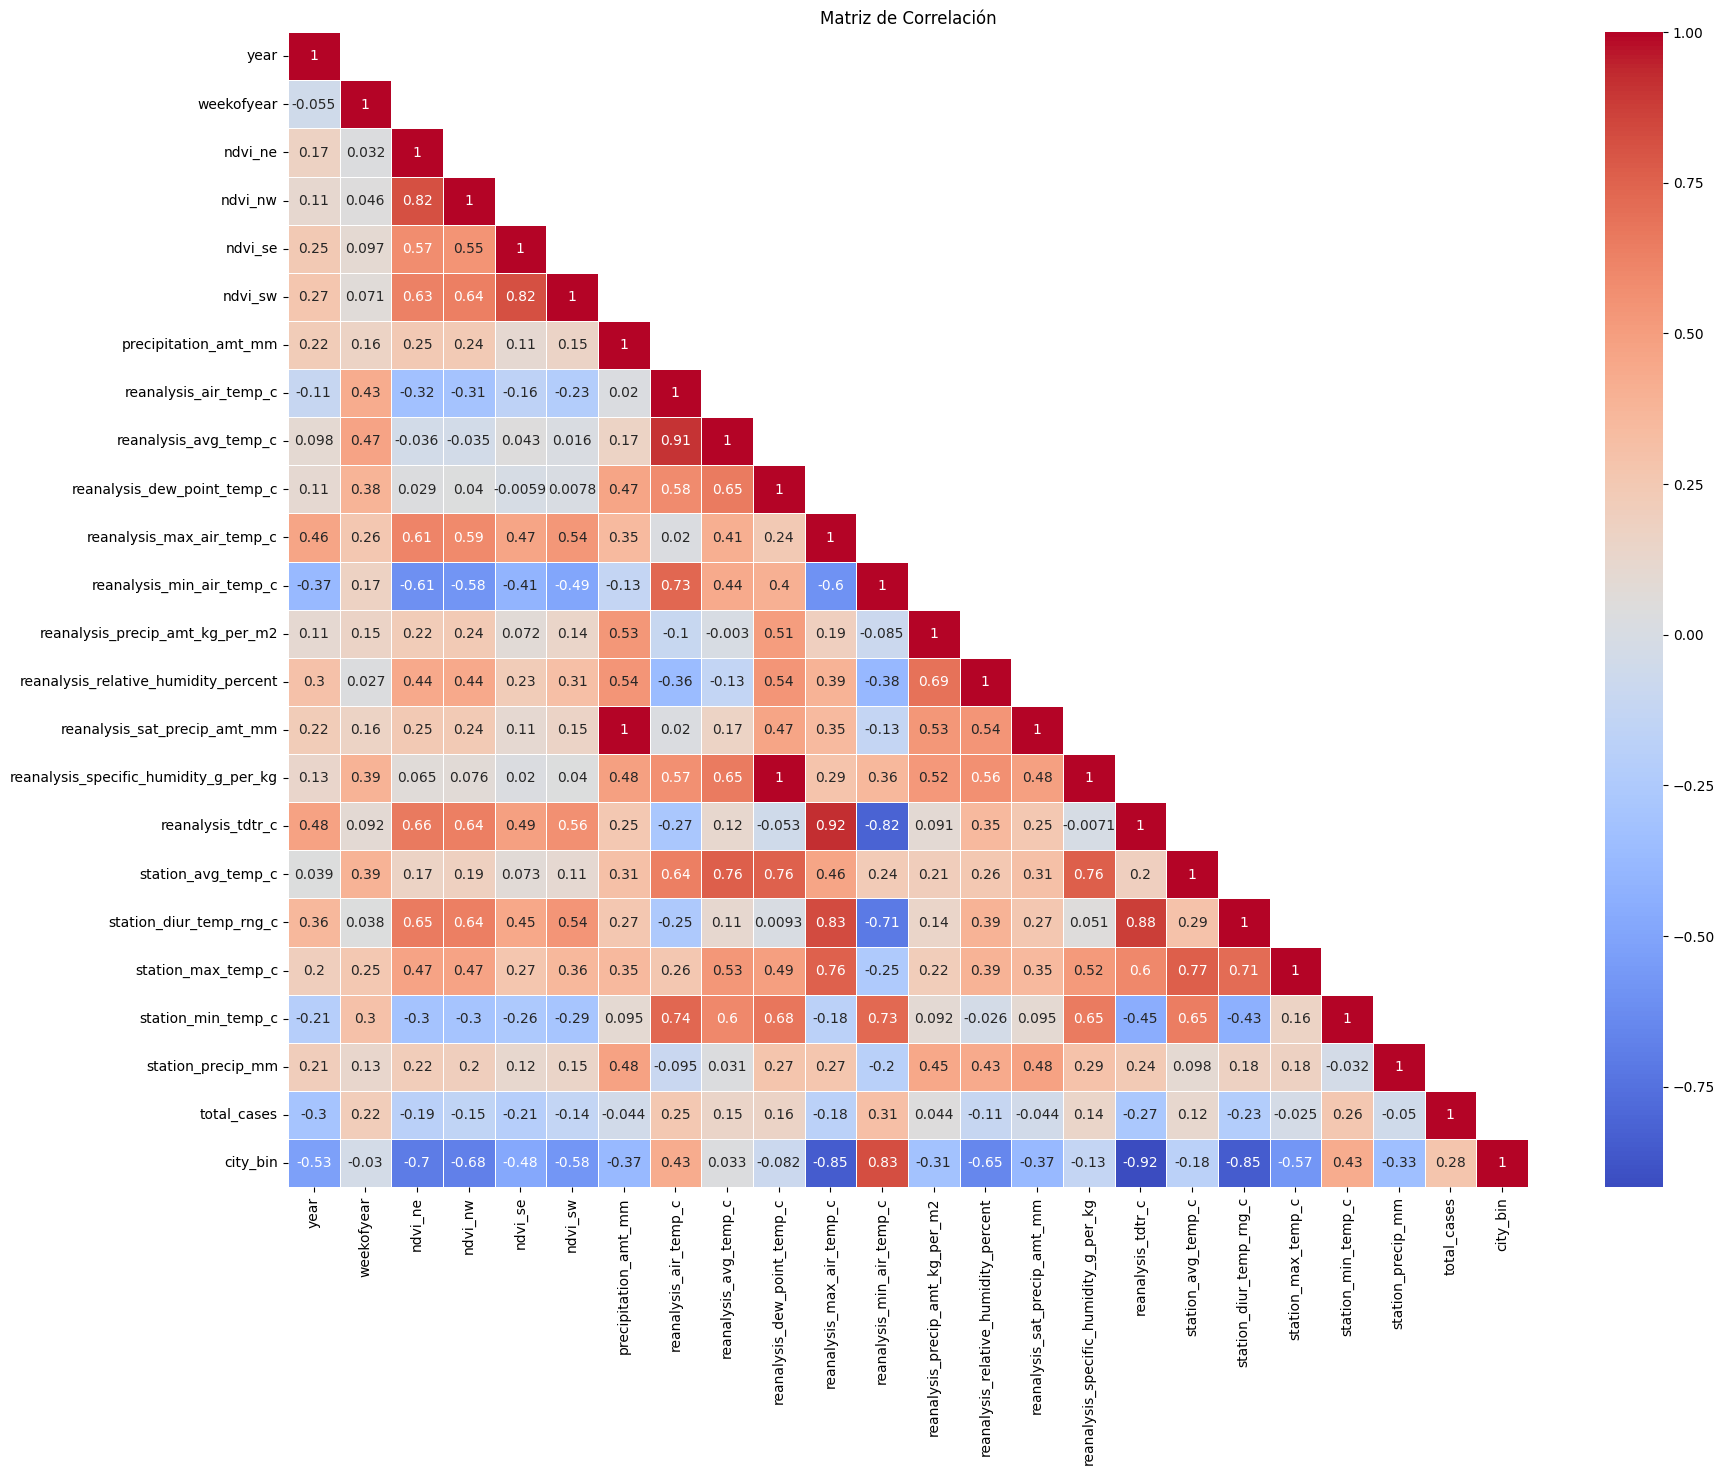

In [ ]:
graficoCorrelacion(train)

Se puede observar variables correlacionadas al máximo como la relación (reanalysis_sat_precip_amt_mm y precipitation_amt_mm) y (reanalysis_specific_humidity_g_per_kg y reanalysis_dew_point_temp_c)

Además de otras relaciones mayor a 0.9 como las de (reanalysis_avg_temp_c y reanalysis_air_temp_c) y (reanalysis_tdtr_c y reanalysis_max_air_temp_c)

Para este caso como las variables están aportando básicamente la misma información se optará dejar una de ellas por cada grupo, en este caso se eliminarán las que tengan menos peso en la variable objetivo reanalysis_sat_precip_amt_mm, reanalysis_specific_humidity_g_per_kg, reanalysis_avg_temp_c y reanalysis_max_air_temp_c.



In [ ]:
train.drop(columns=['reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_avg_temp_c' , 'reanalysis_max_air_temp_c'], inplace=True)
test.drop(columns=['reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_avg_temp_c' , 'reanalysis_max_air_temp_c'], inplace=True)


Se visualiza nuevamente el diagrama de correlacion.

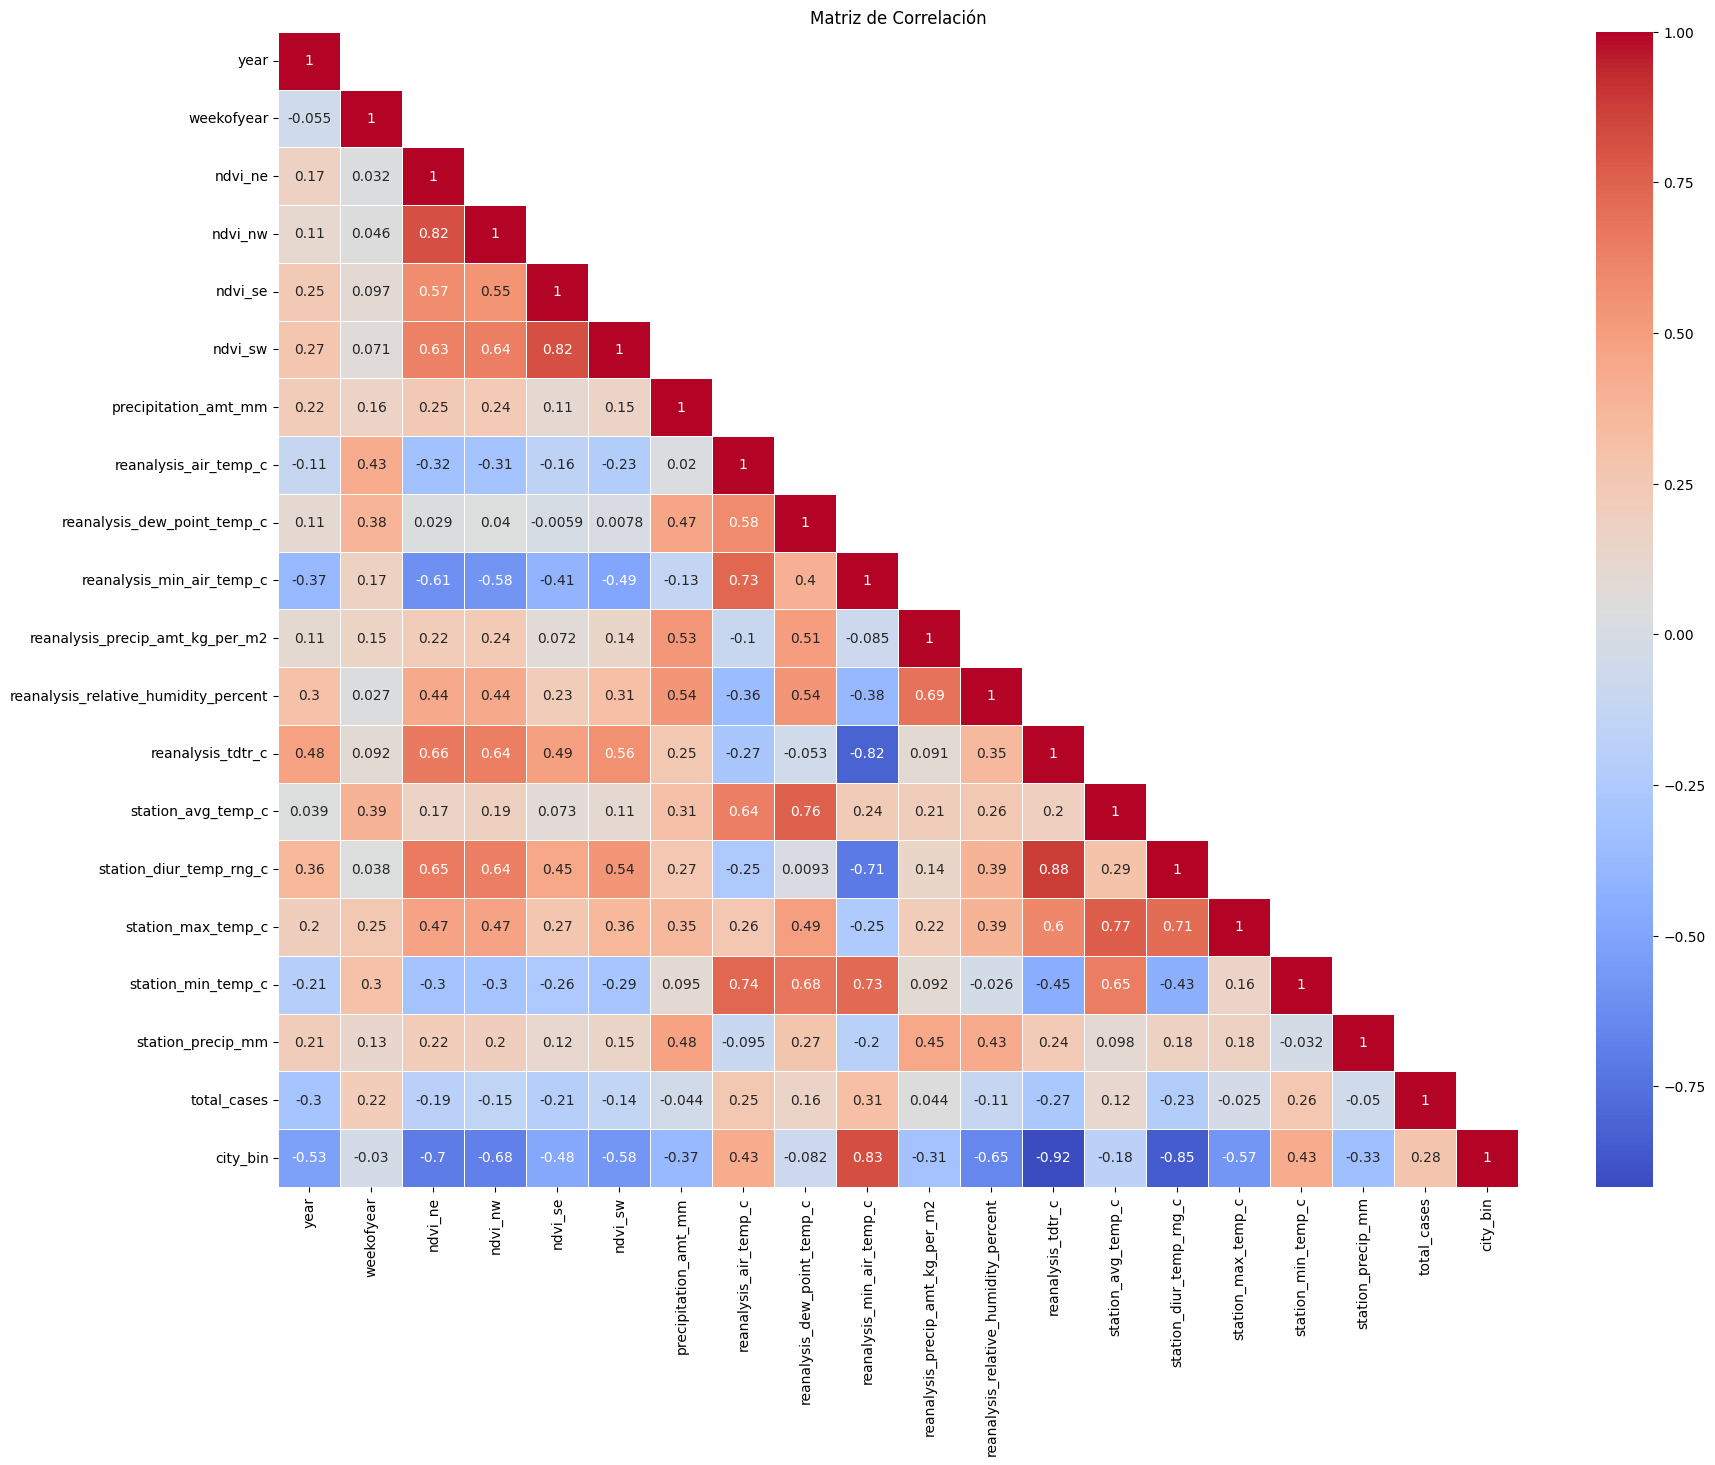

In [ ]:
graficoCorrelacion(train)

Después de eliminar las variables que tenían más correlación se puede observar en este grafico que aún existen dos relaciones con más o igual de 0.8 de correlación que son (ndvi_sw,ndvi_se) y (station_diur_temp_rng_c, reanalysis_tdtr_c)

Se elimina la ndvi_sw porque se ve que en general tiene menor correlación con el target; y de la otra relación se elimina station_diur_temp_rng_c.


In [ ]:
train.drop(columns=['ndvi_sw', 'station_diur_temp_rng_c'], inplace=True)
test.drop(columns=['ndvi_sw', 'station_diur_temp_rng_c'], inplace=True)


Ya con esto las correlaciones altas se han eliminado y las características de nuestro dataFrame disminuyeron un poco.

In [ ]:
train.dtypes

,0
year,int64
weekofyear,int64
ndvi_ne,float64
ndvi_nw,float64
ndvi_se,float64
precipitation_amt_mm,float64
reanalysis_air_temp_c,float64
reanalysis_dew_point_temp_c,float64
reanalysis_min_air_temp_c,float64
reanalysis_precip_amt_kg_per_m2,float64


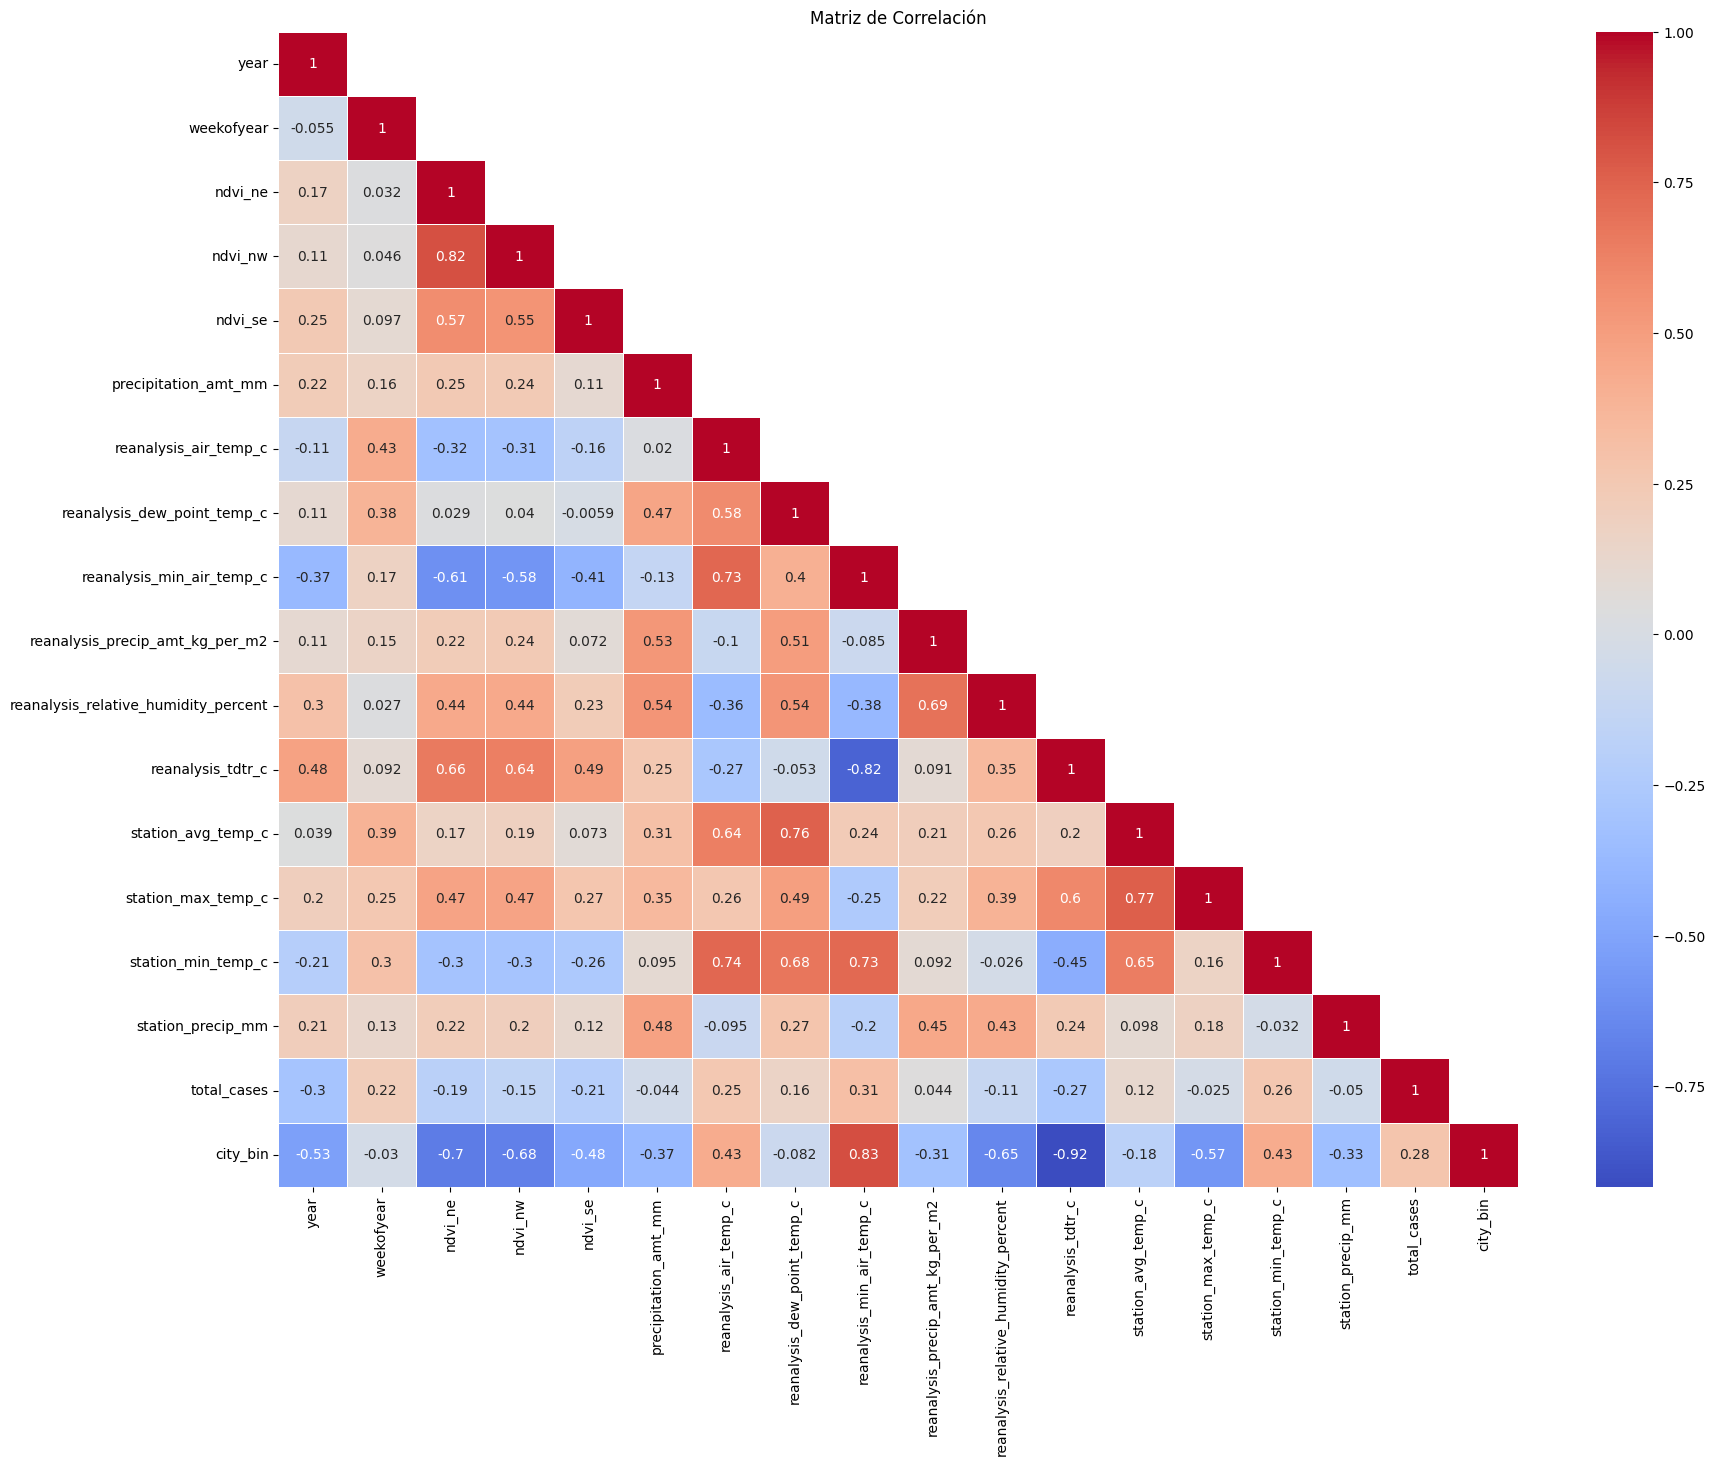

In [ ]:
graficoCorrelacion(train)

Se puede observar que aún existen variables que miden fenómenos parecidos, como temperatura, humedad, precipitaciones, etc. Para ayudar a nuestro modelo vamos a evaluar variables que tengan la misma unidad de medida y la reduciremos en base a su correlación usando PCA.

Analizando este grafico vemos que se puede reducir la dimensionalidad de grupos de variables que al parecer expresan la misma informacion.

Grupo 1 (ndvi):
* ndvi_nw
* ndvi_ne

Grupo 2 (Temperatura máxima y promedio):
* station_max_temp_c
* station_avg_temp_c



In [ ]:
from sklearn.decomposition import PCA

def pcaN_Uno(df, columns_to_pca, new_column_name):
    # Seleccionar columnas para PCA
    df_pca = df[columns_to_pca]

    # Aplicar PCA
    pca = PCA(n_components=1)
    principal_components = pca.fit_transform(df_pca)

    # Ver la varianza explicada
    print(f"Varianza explicada para {new_column_name}:", pca.explained_variance_ratio_)
    print(f"Coeficientes de carga para {new_column_name}:", pca.components_)

    # Añadir el componente principal al DataFrame
    df[new_column_name] = principal_components.flatten()

    # Eliminar las columnas originales usadas para PCA
    df.drop(columns=columns_to_pca, inplace=True)

    return df
#References:
#codigo proporcionado en clases y adaptado a funcion para poder reutilizarlo mediante Gemini IA

In [ ]:
columns_group_1 = ['ndvi_nw', 'ndvi_ne']
train = pcaN_Uno(train, columns_group_1, 'ndvi_n')
test = pcaN_Uno(test, columns_group_1, 'ndvi_n')

columns_group_2 = ['station_max_temp_c', 'station_avg_temp_c']
train = pcaN_Uno(train, columns_group_2, 'station_temp_c')
test = pcaN_Uno(test, columns_group_2, 'station_temp_c')

#columns_group_3 = ['station_min_temp_c', 'reanalysis_min_air_temp_c','reanalysis_air_temp_c']
#train = pcaN_Uno(train, columns_group_3, 'temp_min_c')
#test = pcaN_Uno(test, columns_group_3, 'temp_min_c')

Varianza explicada para ndvi_n: [0.91116638]
Coeficientes de carga para ndvi_n: [[0.64200409 0.76670121]]
Varianza explicada para ndvi_n: [0.91291457]
Coeficientes de carga para ndvi_n: [[0.64419816 0.76485864]]
Varianza explicada para station_temp_c: [0.90341466]
Coeficientes de carga para station_temp_c: [[0.86077144 0.50899168]]
Varianza explicada para station_temp_c: [0.8842358]
Coeficientes de carga para station_temp_c: [[0.88155181 0.47208729]]


La varianza es muy buena en todos los casos.

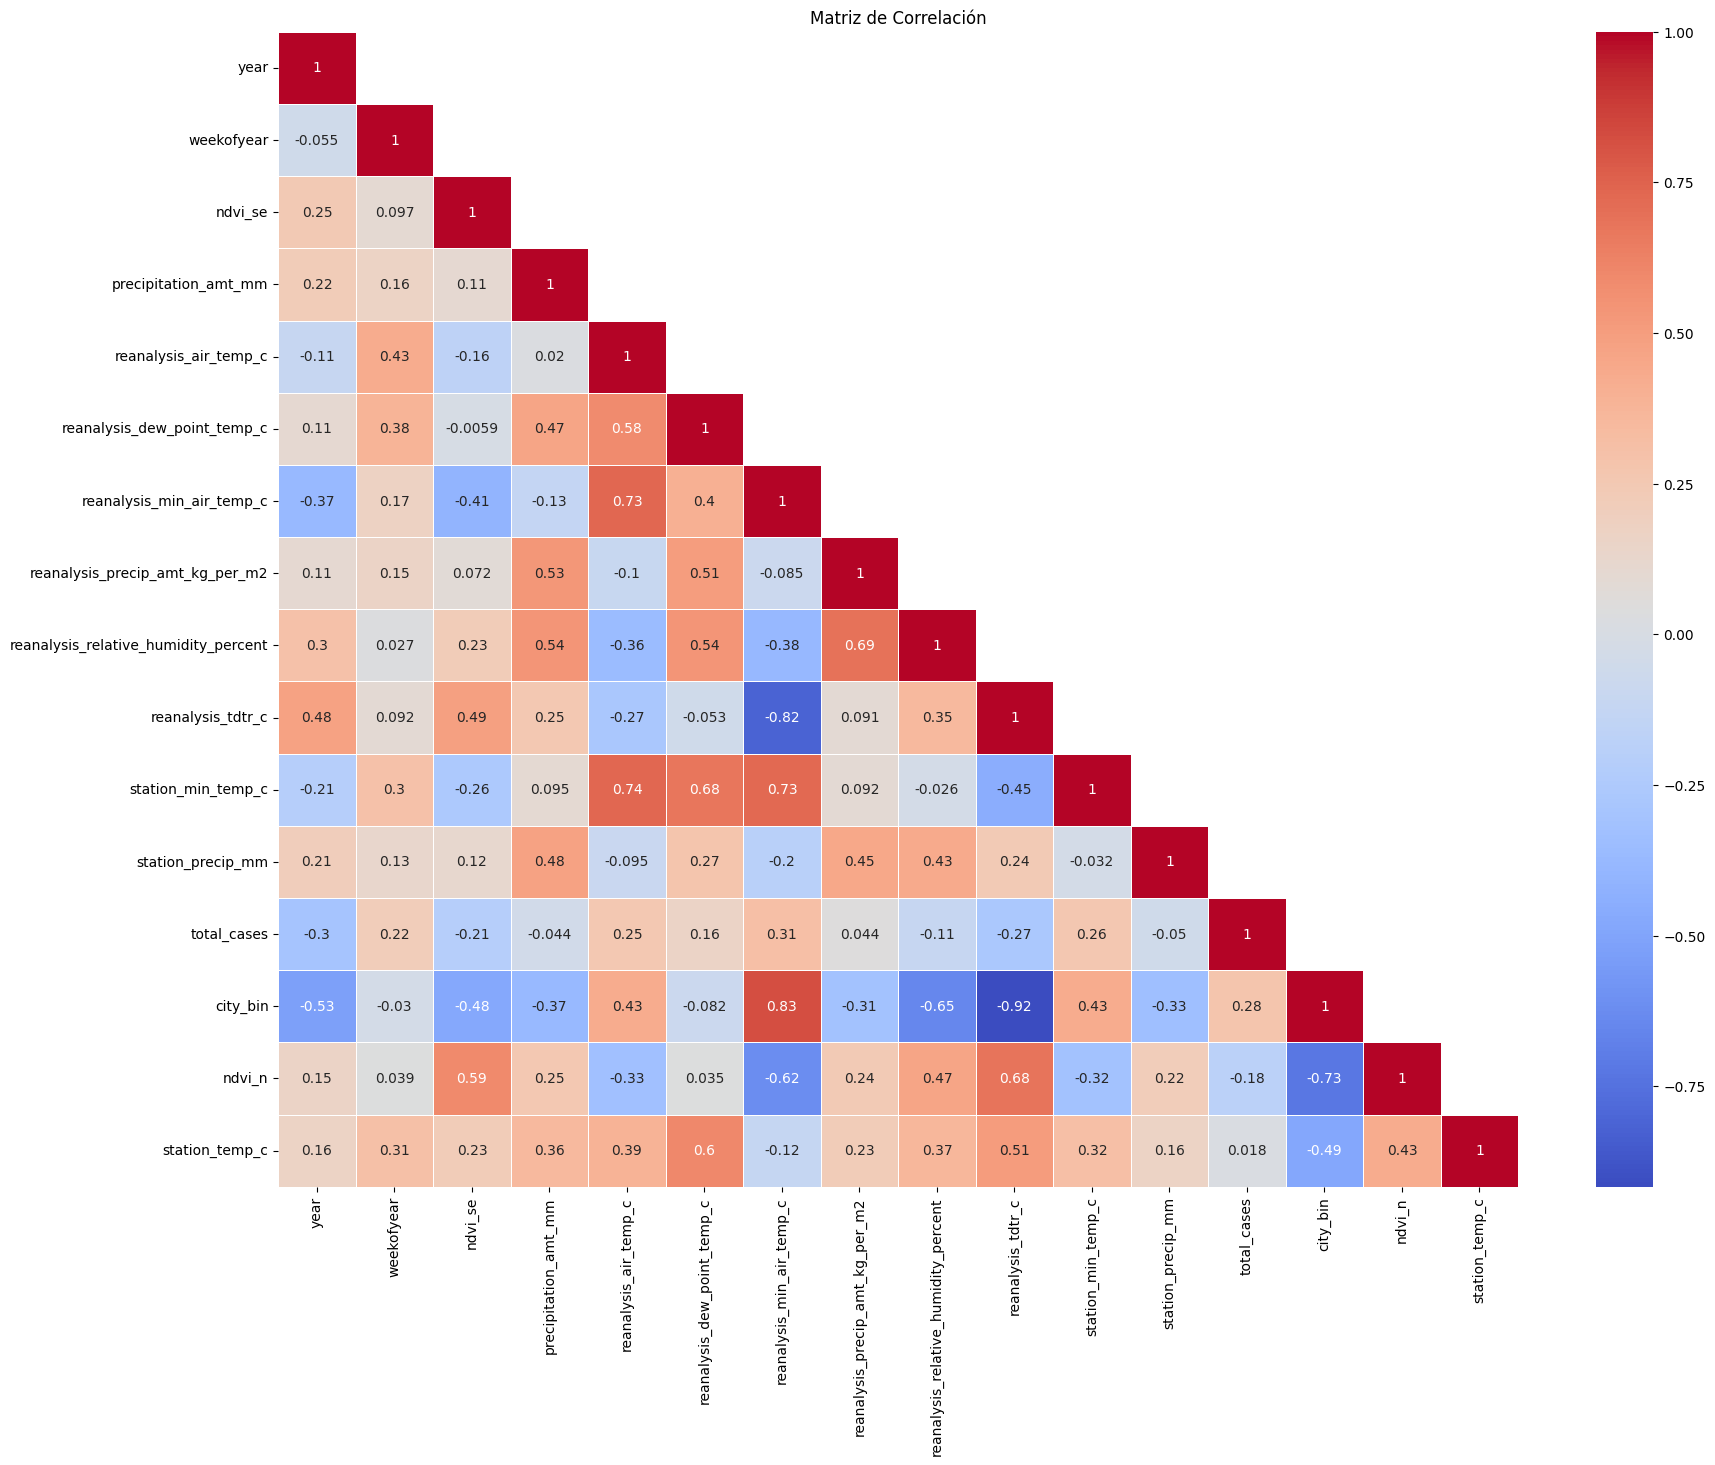

In [ ]:
graficoCorrelacion(train)

Se logro reducir la dimencionalidad del dataFrame.

Relación entre la ciudad y el número de casos de dengue.

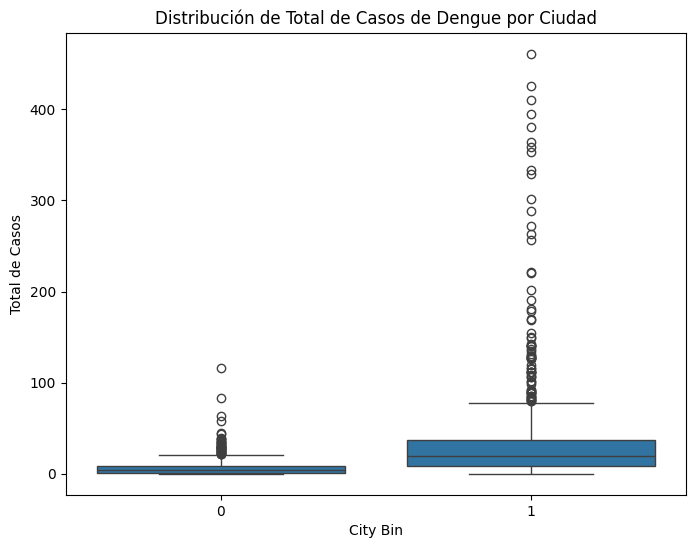

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x='city_bin', y='total_cases', data=train)
plt.title('Distribución de Total de Casos de Dengue por Ciudad')
plt.xlabel('City Bin')
plt.ylabel('Total de Casos')
plt.show()


Se puede apreciar que dependiendo de la ciudad los casos de dengue pueden ser mucho más grandes a comparación que la otra, por lo que esta variable es importante.

In [ ]:
from scipy.stats import pointbiserialr

# Calcular la correlación Point-Biserial
correlation, p_value = pointbiserialr(train['city_bin'], train['total_cases'])
print(f"Correlación Point-Biserial: {correlation}, p-valor: {p_value}")


Correlación Point-Biserial: 0.27696956299868414, p-valor: 7.548030469473848e-25


Como el p-value es significativo indica que la relación es estadisticamente significativa.

In [ ]:
#Se renombra la columna ndvi_se a ndvi_s, para que solo represente al sur
train.rename(columns={'ndvi_se': 'ndvi_s'}, inplace=True)
test.rename(columns={'ndvi_se': 'ndvi_s'}, inplace=True)

Se muestra los valores maximos y minimos de las variables respectivas para decidir la normalización


In [ ]:
minMax = pd.DataFrame({'Valor mínimo': train.min(), 'Valor máximo': train.max()})
print(minMax)


                                      Valor mínimo  Valor máximo
year                                   1990.000000   2010.000000
weekofyear                                1.000000     53.000000
ndvi_s                                   -0.015533      0.538314
precipitation_amt_mm                      0.000000    182.810000
reanalysis_air_temp_c                    21.485714     29.050000
reanalysis_dew_point_temp_c              16.492857     24.991429
reanalysis_min_air_temp_c                13.750000     26.750000
reanalysis_precip_amt_kg_per_m2           0.000000    122.700000
reanalysis_relative_humidity_percent     57.787143     98.341429
reanalysis_tdtr_c                         1.400000     16.028571
station_min_temp_c                       14.700000     25.600000
station_precip_mm                         0.000000    143.300000
total_cases                               0.000000    461.000000
city_bin                                  0.000000      1.000000
ndvi_n                   

Como se ve existen variables con diferentes rangos lo que podria provocar que las que tengan mayor valor predominen en el modelo.

Ademas como no se tiene outliers muy extremos el escalado RobustScaler es una buena opcion y mas robusta estos valores fueras de rango.

En este caso se normaliza las variables referentes a la temperatura, precipitaciones, humedad y vegetación.

In [ ]:
from sklearn.preprocessing import RobustScaler

# Definir las columnas a excluir
#exclude_columns = ['year', 'weekofyear', 'city_bin', 'total_cases']
exclude_columns = ['weekofyear', 'city_bin', 'total_cases']

# Crear la función para normalizar el entrenamiento y el test
def normalizacionNumContinuas(train_df, test_df):
    # Identificar las columnas a normalizar
    columns_to_normalize = [col for col in train_df.columns if col not in exclude_columns]

    # Inicializar el RobustScaler
    scaler = RobustScaler()

    # Ajustar y transformar el conjunto de entrenamiento
    train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])

    # Transformar el conjunto de prueba con los mismos parámetros para evitar data leakage
    test_df[columns_to_normalize] = scaler.transform(test_df[columns_to_normalize])

    return train_df, test_df


In [ ]:
train, test = normalizacionNumContinuas(train, test)

In [ ]:
train.head()

,year,weekofyear,ndvi_s,precipitation_amt_mm,reanalysis_air_temp_c,reanalysis_dew_point_temp_c,reanalysis_min_air_temp_c,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_tdtr_c,station_min_temp_c,station_precip_mm,total_cases,city_bin,ndvi_n,station_temp_c
0,-1.333333,18,0.042127,-0.369034,-0.516773,-1.258230,-0.102564,0.227170,-0.878924,-0.030748,-1.000000,-0.131720,4,1,0.048110,-1.339436
1,-1.333333,19,-0.348223,-0.186361,-0.224186,-0.628530,0.025641,-0.209171,-0.324813,-0.081062,0.000000,-0.330645,5,1,0.285320,-0.431910
2,-1.333333,20,-0.403946,0.019497,0.036982,-0.021068,0.256410,0.044069,0.323627,-0.095038,0.272727,0.551075,4,1,-0.048479,-0.283224
3,-1.333333,21,0.356275,-0.317393,0.131239,-0.071982,0.179487,-0.334549,0.086123,-0.069881,0.500000,-0.454301,3,1,0.419269,0.177022
4,-1.333333,22,0.611741,-0.455100,0.374734,0.137527,0.307692,-0.387307,0.103129,0.044724,0.772727,-0.405914,6,1,0.663691,0.941293


In [ ]:
test.head()

,year,weekofyear,ndvi_s,precipitation_amt_mm,reanalysis_air_temp_c,reanalysis_dew_point_temp_c,reanalysis_min_air_temp_c,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_tdtr_c,station_min_temp_c,station_precip_mm,city_bin,ndvi_n,station_temp_c
0,0.666667,18,-0.992520,0.793396,-0.095238,-0.392685,0.025641,0.021414,-0.129233,0.067086,-0.227273,1.459677,1,-0.649562,-0.053090
1,0.666667,19,-1.216033,-0.366574,-0.103093,-0.446525,0.102564,-0.088448,-0.205567,-0.041929,0.000000,0.360215,1,-0.630587,-1.132665
2,0.666667,20,-0.470038,-0.522900,0.345934,-0.072568,0.025641,-0.638063,-0.200030,0.321454,0.272727,-0.481183,1,-0.581471,0.022964
3,0.666667,21,-0.759128,-0.587187,0.453281,-0.443599,0.153846,-0.697649,-0.927374,0.304682,1.000000,-0.553763,1,-0.600191,0.196209
4,0.666667,22,-1.429718,-0.573837,0.494518,-0.297293,0.256410,-0.630615,-0.779453,0.148148,0.500000,1.698925,1,-0.276971,0.123982


In [ ]:
minMax = pd.DataFrame({'Valor mínimo': train.min(), 'Valor máximo': train.max()})
print(minMax)

                                      Valor mínimo  Valor máximo
year                                     -1.333333      0.888889
weekofyear                                1.000000     53.000000
ndvi_s                                   -2.270362      3.714064
precipitation_amt_mm                     -0.587187      2.623809
reanalysis_air_temp_c                    -1.862543      1.603338
reanalysis_dew_point_temp_c              -2.393563      1.087930
reanalysis_min_air_temp_c                -2.410256      0.923077
reanalysis_precip_amt_kg_per_m2          -0.765924      3.041974
reanalysis_relative_humidity_percent     -3.035448      2.578435
reanalysis_tdtr_c                        -0.271139      2.591195
station_min_temp_c                       -3.409091      1.545455
station_precip_mm                        -0.561828      3.290323
total_cases                               0.000000    461.000000
city_bin                                  0.000000      1.000000
ndvi_n                   

In [ ]:
minMax = pd.DataFrame({'Valor mínimo': test.min(), 'Valor máximo': test.max()})
print(minMax)

                                      Valor mínimo  Valor máximo
year                                      0.666667      1.222222
weekofyear                                1.000000     53.000000
ndvi_s                                   -2.035529      2.792690
precipitation_amt_mm                     -0.587187      2.387213
reanalysis_air_temp_c                    -1.899853      1.482245
reanalysis_dew_point_temp_c              -1.911924      0.945721
reanalysis_min_air_temp_c                -2.589744      0.871795
reanalysis_precip_amt_kg_per_m2          -0.765924      8.587788
reanalysis_relative_humidity_percent     -2.048055      2.528798
reanalysis_tdtr_c                        -0.254368      2.289308
station_min_temp_c                       -3.636364      2.045455
station_precip_mm                        -0.561828      5.137097
city_bin                                  0.000000      1.000000
ndvi_n                                   -2.008321      2.158494
station_temp_c           

Dado que "weekofyear" es cíclica (vuelve de la semana 52 a la semana 1), el mejor enfoque es utilizar la codificación seno y coseno. Esto conserva la naturaleza cíclica, lo que es clave para que los algoritmos de clustering o reducción de dimensionalidad no vean las semanas 1 y 52 como distantes.

In [ ]:
# 2. Codificación seno-coseno para "weekofyear"
train['weekofyear_sin'] = np.sin(2 * np.pi * train['weekofyear'] / 52)
train['weekofyear_cos'] = np.cos(2 * np.pi * train['weekofyear'] / 52)

test['weekofyear_sin'] = np.sin(2 * np.pi * test['weekofyear'] / 52)
test['weekofyear_cos'] = np.cos(2 * np.pi * test['weekofyear'] / 52)

In [ ]:
train = train.drop(columns=['weekofyear'])
test = test.drop(columns=['weekofyear'])

In [ ]:
minMax = pd.DataFrame({'Valor mínimo ': train.min(), 'Valor máximo ': train.max()})
print(minMax)

                                      Valor mínimo   Valor máximo 
year                                      -1.333333       0.888889
ndvi_s                                    -2.270362       3.714064
precipitation_amt_mm                      -0.587187       2.623809
reanalysis_air_temp_c                     -1.862543       1.603338
reanalysis_dew_point_temp_c               -2.393563       1.087930
reanalysis_min_air_temp_c                 -2.410256       0.923077
reanalysis_precip_amt_kg_per_m2           -0.765924       3.041974
reanalysis_relative_humidity_percent      -3.035448       2.578435
reanalysis_tdtr_c                         -0.271139       2.591195
station_min_temp_c                        -3.409091       1.545455
station_precip_mm                         -0.561828       3.290323
total_cases                                0.000000     461.000000
city_bin                                   0.000000       1.000000
ndvi_n                                    -2.219580       2.07

Debido a que los casos de dengue vienen influenciados por rasgos climáticos como el clima, la humedad, lluvias, etc; los cuales influyen en la población de mosquitos que son el trasmisor de esta enfermedad. Por esto se hará una experimentación con un dataFrame con el año y la semana, y otro sin esos features. Además, al ser esas variables de tiempo podría ser más conveniente modelos temporales.

In [ ]:
#los df con las semanas del año y el año
train_time = train
test_time = test

#dfs sin las variables temporales
trainNoTemps = train.drop(columns=['year', 'weekofyear_sin', 'weekofyear_cos'])
testNoTemps = test.drop(columns=['year', 'weekofyear_sin', 'weekofyear_cos'])

#dfs sin el año, nos enfocamos en la periodicidad de las semanas
train_week = train.drop(columns=['weekofyear_sin', 'weekofyear_cos'])
test_week = test.drop(columns=['weekofyear_sin', 'weekofyear_cos'])

---
# Predicción
---

In [ ]:
# Separar X_train y y_train en base a train
X_trainNoTemps = trainNoTemps.drop(columns=['total_cases']).reset_index(drop=True)  # Características, reset de índice
y_trainNoTemps = trainNoTemps['total_cases'].reset_index(drop=True)
X_testNoTemps = testNoTemps


# Separar X_train y y_train en base a train
X_train_week = train_week.drop(columns=['total_cases']).reset_index(drop=True)  # Características, reset de índice
y_train_week = train_week['total_cases'].reset_index(drop=True)
X_test_week = test_week

# Separar X_train y y_train en base a train
X_train_time = train_time.drop(columns=['total_cases']).reset_index(drop=True)  # Características, reset de índice
y_train_time = train_time['total_cases'].reset_index(drop=True)
X_test_time = test_time

Separamos datos de validacion

In [ ]:
from sklearn.model_selection import train_test_split

X_trainNoTemps, X_valNoTemps, y_trainNoTemps, y_valNoTemps  = train_test_split(X_trainNoTemps, y_trainNoTemps,   test_size=0.2, random_state=seed)
X_train_time,   X_val_time,   y_train_time,   y_val_time    = train_test_split(X_train_time,   y_train_time,     test_size=0.2, random_state=seed)
X_train_week,   X_val_week,   y_train_week,   y_val_week    = train_test_split(X_train_week,   y_train_week,     test_size=0.2, random_state=seed)


## LinearRegression

In [ ]:
# EJEMPLO: Ejecución del algoritmo LinearRegression y generación de su modelo
# NO SE TENDRÁ EN CUENTA PARA EVALUAR LA PRÁCTICA 2, TAMPOCO OTROS LOCO REGRESIÓN LOGÍSTICA NI DE LA FAMILIA DENTRO DE import linear_model
# Nombre del modelo: "LinearRegressionA"
from sklearn import linear_model
regLineal = linear_model.LinearRegression()
regLineal2 = linear_model.LinearRegression()
regLineal3 = linear_model.LinearRegression()

regLineal.fit(X_trainNoTemps, y_trainNoTemps)
regLineal2.fit(X_train_time, y_train_time)
regLineal3.fit(X_train_week, y_train_week)

# Predicción sobre el conjunto de test
y_pred = regLineal.predict(X_testNoTemps)
y_pred2 = regLineal2.predict(X_test_time)
y_pred3 = regLineal3.predict(X_test_week)


In [ ]:
# Predicción sobre el conjunto de validación
y_val_pred = regLineal.predict(X_valNoTemps)
y_val_pred2 = regLineal2.predict(X_val_time)
y_val_pred3 = regLineal3.predict(X_val_week)

# Redondeo y ajuste de valores predichos
y_val_pred = np.rint(y_val_pred)  # Redondear a enteros
y_val_pred2 = np.rint(y_val_pred2)  # Redondear a enteros
y_val_pred3 = np.rint(y_val_pred3)  # Redondear a enteros

y_val_pred = y_val_pred.astype(int)  # Convertir a enteros
y_val_pred2 = y_val_pred2.astype(int)  # Convertir a enteros
y_val_pred3 = y_val_pred3.astype(int)  # Convertir a enteros

y_val_pred = np.hstack(y_val_pred)
y_val_pred2 = np.hstack(y_val_pred2)
y_val_pred3 = np.hstack(y_val_pred3)

y_val_pred[y_val_pred < 0] = 0      # Ajustar valores negativos a 0
y_val_pred2[y_val_pred2 < 0] = 0
y_val_pred3[y_val_pred3 < 0] = 0

y_val_pred2

array([ 0, 60, 52, 68, 52, 22, 23, 29, 49, 34, 26, 20, 13, 25, 73, 17, 33,
       29, 23, 52, 18,  0, 52, 12, 10, 50, 29, 50,  0, 29, 29, 70, 21, 16,
       17, 12, 20,  0, 72, 49,  7, 17, 63, 28,  0,  0, 39, 10,  1, 10,  0,
       24, 18, 28, 29, 41,  1, 34, 34, 62, 25,  0, 57, 59, 34, 30,  3,  0,
        7, 14, 65, 44,  2, 48,  0, 20, 69, 18, 34, 10, 31,  0, 18,  0, 22,
       62, 26, 40,  0, 29,  0, 30, 36,  0, 27, 30, 74, 59, 26, 41,  9, 38,
       43, 19,  0, 48, 12, 60, 18, 60,  0, 54,  4,  8,  6, 30, 73,  0, 65,
       22,  0, 37, 40, 57,  8,  0, 41, 47,  5,  0, 40,  0,  0, 31, 12,  9,
       24, 19, 51, 20, 11,  0,  0,  6, 17,  5,  0, 45,  0, 48,  3, 25, 21,
       38, 50, 72, 16,  8,  0, 18, 10, 15, 13, 44, 61, 21, 13, 28, 17,  0,
       49, 12, 27, 20, 22, 38, 27, 48,  0, 17, 35,  0, 46,  5,  4, 35, 36,
       12, 42, 68,  0,  0,  0,  0,  0, 20,  8, 28, 28, 56, 42,  4, 15, 49,
       25, 39,  2, 41, 32, 31, 14,  0, 40, 39, 15, 64, 14, 31, 52, 42, 19,
       15, 17,  1, 44, 18

Validamos con el conjunto de validacion las metricas.

In [ ]:
# Medir la eficiencia del modelo usando el conjunto de validación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_val = mean_squared_error(y_val_time, y_val_pred2)
mae_val = mean_absolute_error(y_val_time, y_val_pred2)
r2_val = r2_score(y_val_time, y_val_pred2)

print('')
print("Mean Squared Error (MSE) en validación:", mse_val)
print("Mean Absolute Error (MAE) en validación:", mae_val)
print("R² Score en validación:", r2_val)

mse_val2 = mean_squared_error(y_val_week, y_val_pred3)
mae_val2 = mean_absolute_error(y_val_week, y_val_pred3)
r2_val2 = r2_score(y_val_week, y_val_pred3)

print('')
print("Mean Squared Error (MSE) en validación sin el año:", mse_val2)
print("Mean Absolute Error (MAE) en validación sin el año:", mae_val2)
print("R² Score en validación sin el año:", r2_val2)

mse_val1 = mean_squared_error(y_valNoTemps, y_val_pred)
mae_val1 = mean_absolute_error(y_valNoTemps, y_val_pred)
r2_val1 = r2_score(y_valNoTemps, y_val_pred)

print('')
print("Mean Squared Error (MSE) en validación sin año y semanas:", mse_val1)
print("Mean Absolute Error (MAE) en validación sin año y semanas:", mae_val1)
print("R² Score en validación sin año y semanas:", r2_val1)



Mean Squared Error (MSE) en validación: 1234.548872180451
Mean Absolute Error (MAE) en validación: 18.601503759398497
R² Score en validación: 0.311037869186925

Mean Squared Error (MSE) en validación sin el año: 1382.063909774436
Mean Absolute Error (MAE) en validación sin el año: 20.454887218045112
R² Score en validación sin el año: 0.22871445784378341

Mean Squared Error (MSE) en validación sin año y semanas: 1495.1766917293232
Mean Absolute Error (MAE) en validación sin año y semanas: 21.26691729323308
R² Score en validación sin año y semanas: 0.16558984201533622


Como BaseLine podemos ver que el modelo de regresión con el dataSet con las variables temporales de weekofyear y year se obtiene mejores métricas si se las compara con los dataSets en donde se prescindieron de esas variables.


Probamos otros algoritmos con el df con las variables de año y semana las cuales le suman al modelo.

## KNN

Usaremos la optimización de parametros para encontrar las parametrizaciones mas optimas.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

#se instancia el modelo
knn = KNeighborsRegressor()

# Definir el primer espacio de hiperparámetros a explorar
param_dist = {
    'n_neighbors': np.arange(1, 31),  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Tipo de ponderación
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo para calcular los vecinos
}

#combinaciones: https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

def buscar_mejor_knn(param_dist, X_train, y_train, n_iter=100):
    # Definir el modelo
    knn = KNeighborsRegressor()

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=knn,
        param_distributions=param_dist,
        n_iter=n_iter,               # Número de combinaciones aleatorias a probar
        cv=5,                     # Número de pliegues para la validación cruzada
        random_state=seed,        # Semilla para reproducibilidad
        n_jobs=-1                 # Utilizar todos los núcleos disponibles
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Obtener los mejores parámetros y el mejor estimador
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    best_estimator = random_search.best_estimator_

    # Imprimir los mejores parámetros y la mejor puntuación
    print("Mejores parámetros:", best_params)
    print("Mejor puntuación:", best_score)

    return best_estimator

#codigo proporcionado en clase y adaptado a función con ayuda de ChatGpt

Probamos con los 3 dataSets para comparar el mejor de ellos.

In [ ]:
#train con los parametros de year y weekofyear
best_knn = buscar_mejor_knn(param_dist, X_train_time, y_train_time)

Mejores parámetros: {'weights': 'distance', 'n_neighbors': 23, 'algorithm': 'kd_tree'}
Mejor puntuación: 0.3106537734061931


In [ ]:
#train con los parametros sin  year
best_knnNoYear = buscar_mejor_knn(param_dist, X_train_week, y_train_week)

Mejores parámetros: {'weights': 'distance', 'n_neighbors': 17, 'algorithm': 'ball_tree'}
Mejor puntuación: 0.17498711008172113


In [ ]:
#train sin year y weekofyear
best_knnNoDates = buscar_mejor_knn(param_dist, X_trainNoTemps, y_trainNoTemps)

Mejores parámetros: {'weights': 'distance', 'n_neighbors': 23, 'algorithm': 'auto'}
Mejor puntuación: 0.12974578079682064


Se puede ver nuevamente que los parametros de year y weekofyear son importantes para la variable objetivo de nuestros datos.

In [ ]:
# Hacer predicciones con el mejor modelo encontrado
y_val_predK = best_knn.predict(X_val_time)

# Evaluar el modelo
y_val_predK = np.rint(y_val_predK)  # Redondear a enteros
y_val_predK = y_val_predK.astype(int)  # Convertir a enteros
y_val_predK[y_val_predK < 0] = 0  # Ajustar valores negativos a 0

# Calcular métricas
mse_val = mean_squared_error(y_val_time, y_val_predK)
mae_val = mean_absolute_error(y_val_time, y_val_predK)
r2_val = r2_score(y_val_time, y_val_predK)


print("Mean Squared Error (MSE) en validación:", mse_val)
print("Mean Absolute Error (MAE) en validación:", mae_val)
print("R² Score en validación:", r2_val)

Mean Squared Error (MSE) en validación: 1039.4624060150377
Mean Absolute Error (MAE) en validación: 16.274436090225564
R² Score en validación: 0.4199093690933865


Este algoritmo mejoro un poco lo presentado por el de regresion lineal, exploraremos otras opciones para ver otras mejoras.

In [ ]:
#nuevos parametros
param_dist = {
    'n_neighbors': np.arange(1, 101),         # Probar con un rango de vecinos de 1 a 1000
    'weights': ['uniform', 'distance'],         # Dos opciones de peso
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Diferentes algoritmos de búsqueda
    'leaf_size': np.arange(10, 51, 10),         # Tamaños de hoja de 10 a 50
    'p': [1, 2],                                # Distancia de Manhattan (1) y Euclidiana (2)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Métricas de distancia
}

#Combinaciones: https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [ ]:
#train con los parametros de year y weekofyear, duplicamos el numero de n_iter
best_knn = buscar_mejor_knn(param_dist, X_train_time, y_train_time,300)

Mejores parámetros: {'weights': 'distance', 'p': 2, 'n_neighbors': 14, 'metric': 'manhattan', 'leaf_size': 40, 'algorithm': 'auto'}
Mejor puntuación: 0.38278774487105593


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


La puntuacion mejoro un poco, se calcula las metricas para ver su mejora.

In [ ]:
# Hacer predicciones con el mejor modelo encontrado
# Hacer predicciones con el mejor modelo encontrado
y_val_predK = best_knn.predict(X_val_time)

# Evaluar el modelo
y_val_predK = np.rint(y_val_predK)  # Redondear a enteros
y_val_predK = y_val_predK.astype(int)  # Convertir a enteros
y_val_predK[y_val_predK < 0] = 0  # Ajustar valores negativos a 0

# Calcular métricas
mse_val = mean_squared_error(y_val_time, y_val_predK)
mae_val = mean_absolute_error(y_val_time, y_val_predK)
r2_val = r2_score(y_val_time, y_val_predK)


print("Mean Squared Error (MSE) en validación:", mse_val)
print("Mean Absolute Error (MAE) en validación:", mae_val)
print("R² Score en validación:", r2_val)

Mean Squared Error (MSE) en validación: 999.672932330827
Mean Absolute Error (MAE) en validación: 16.018796992481203
R² Score en validación: 0.44211459821889454


Las métricas mejoraron por lo que lo encontrado con más combinaciones fue buena idea. Como el total_cases va de 0 a 461, podemos realizar un calcula de la proporción de error con MAE:

Proporcion = $\frac{16.02}{461}$ = 0.0374


Esto indica que, en promedio, las predicciones están a un 3.74% del valor real, lo cual podría ser considerado razonable.

In [ ]:
#Codigo para evaluar los modelos con el test
def descargar_predicciones(modelo, X_test, testLabels):
    # Realizar predicciones
    y_test_pred = modelo.predict(X_test)

    # Ajustar predicciones
    y_test_pred = np.rint(y_test_pred)  # Redondear a enteros
    y_test_pred = y_test_pred.astype(int)  # Convertir a enteros
    y_test_pred[y_test_pred < 0] = 0  # Ajustar valores negativos a 0

    # Descargar predicciones
    download_predictions(testLabels, y_test_pred)

    return y_test_pred


In [ ]:
y_test_pred_knn = descargar_predicciones(best_knn, X_test_time, testLabels)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241106143847.csv


## Árboles de decisión - Regresión

In [ ]:
#modificamos la funcion para incluir tambien el modelo a optimizar
import warnings


warnings.filterwarnings('ignore')

def buscar_mejor_modelo(param_dist, X_train, y_train, modelo, n_iter=100):
    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=modelo,
        param_distributions=param_dist,
        n_iter=n_iter,               # Número de combinaciones aleatorias a probar
        cv=5,                        # Número de pliegues para la validación cruzada
        random_state=seed,          # Semilla para reproducibilidad
        n_jobs=-1                   # Utilizar todos los núcleos disponibles
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Obtener los mejores parámetros y el mejor estimador
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    best_estimator = random_search.best_estimator_

    # Imprimir los mejores parámetros y la mejor puntuación
    print("Mejores parámetros:", best_params)
    print("Mejor puntuación:", best_score)

    return best_estimator

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Definir el modelo
dt_regressor = DecisionTreeRegressor()

# Definir la búsqueda de hiperparámetros con la mayor de combinaciones posibles

param_dist_dt = {
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'max_depth': [None] + list(range(1, 31)),  # Profundidades de 1 a 30
    'min_samples_split': list(range(2, 21)),  # Entre 2 y 20
    'min_samples_leaf': list(range(1, 21)),   # Entre 1 y 20
    'max_features': [None, 'sqrt', 'log2'] + list(range(1, X_train_time.shape[1] + 1)),  # Todas las características, sqrt, log2 y enteros
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None] + list(range(1, 21)),  # Entre 1 y 20
    'min_weight_fraction_leaf': [0.0, 0.1],  # Ejemplo de valores
    'ccp_alpha': [0.0, 0.01, 0.1]  # Ejemplo de valores
}

#Hiperparametros: https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [ ]:
#debido a que el número de combinaciones alto, ponemos iteraciones mas elevadas (aunque no hay que exagerar ya que el proceso puede ser lento)
best_dt = buscar_mejor_modelo(param_dist_dt, X_train_time, y_train_time,dt_regressor,5000)

Mejores parámetros: {'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_leaf_nodes': None, 'max_features': 10, 'max_depth': 26, 'criterion': 'friedman_mse', 'ccp_alpha': 0.01}
Mejor puntuación: 0.6608240093405404


Después de varias ejecuciones se puede notar que los parametros que no varian son:
* 'splitter': 'best'
* 'min_weight_fraction_leaf': 0.0
* 'criterion':'friedman_mse'
* 'ccp_alpha': 0.01

Por ello se hará otra optimización de parámetros con esos valores constantes y variando solo el resto.


In [ ]:
# Definir el modelo
dt_regressor = DecisionTreeRegressor(
    splitter='best',
    min_weight_fraction_leaf=0.0,
    criterion='friedman_mse',
    ccp_alpha=0.01
)

# Se define un universo con algunos parametros fijos

param_dist_dt = {
    'max_depth': [None] + list(range(1, 31)),  # Profundidades de 1 a 30
    'min_samples_split': list(range(2, 21)),  # Entre 2 y 20
    'min_samples_leaf': list(range(1, 21)),   # Entre 1 y 20
    'max_features': [None, 'sqrt', 'log2'] + list(range(1, X_train_time.shape[1] + 1)),  # Todas las características, sqrt, log2 y enteros
    'max_leaf_nodes': [None] + list(range(1, 21))  # Entre 1 y 20

}

In [ ]:
best_dt = buscar_mejor_modelo(param_dist_dt, X_train_time, y_train_time,dt_regressor,5000)

Mejores parámetros: {'min_samples_split': 12, 'min_samples_leaf': 1, 'max_leaf_nodes': 19, 'max_features': 15, 'max_depth': 10}
Mejor puntuación: 0.6272682811200307


Con esto más refinado tenemos una puntuación entre 0.57 a 0.62 lo cual refleja un mejor Score a comparación con los algoritmos anteriores.

In [ ]:
# Hacer predicciones con el mejor modelo encontrado
y_val_predTree = best_dt.predict(X_val_time)

# Evaluar el modelo
y_val_predTree = np.rint(y_val_predTree)  # Redondear a enteros
y_val_predTree = y_val_predTree.astype(int)  # Convertir a enteros
y_val_predTree[y_val_predTree < 0] = 0  # Ajustar valores negativos a 0

# Calcular métricas
mse_val = mean_squared_error(y_val_time, y_val_predTree)
mae_val = mean_absolute_error(y_val_time, y_val_predTree)
r2_val = r2_score(y_val_time, y_val_predTree)


print("Mean Squared Error (MSE) en validación:", mse_val)
print("Mean Absolute Error (MAE) en validación:", mae_val)
print("R² Score en validación:", r2_val)

Mean Squared Error (MSE) en validación: 680.9473684210526
Mean Absolute Error (MAE) en validación: 14.503759398496241
R² Score en validación: 0.6199851131933558


Nuestras metricas mejoraron un poco.
Si ponemos en terminos de proporcion el MAE con el valor real que tenemos:

Proporcion = $\frac{14.50}{461}$ = 0.0315


Las predicciones están a un 3.15% del valor real, lo cual es un muy cercado a lo obtenido con KNN

In [ ]:
#Descargamos las predicciones
y_test_pred_dt = descargar_predicciones(best_dt, X_test_time, testLabels)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241106145216.csv


## XGBRegressor

In [ ]:
from xgboost import XGBRegressor

# Definir el modelo XGBoost
xgb_model = XGBRegressor()

# Definir los hiperparámetros
param_dist_xg = {
    'n_estimators': np.arange(1, 31),
    'max_depth': np.arange(1, 21),
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

#Total de combinaciones = 30 * 20 * 3 * 3 * 3 = 16200
#Parametros: https://xgboost.readthedocs.io/en/stable/parameter.html

In [ ]:
best_xg = buscar_mejor_modelo(param_dist_xg, X_train_time, y_train_time,xgb_model,500)

Mejores parámetros: {'subsample': 0.8, 'n_estimators': 25, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Mejor puntuación: 0.7403951287269592


Da un score aproximado de 0.74 lo cual es ya muy destacable.

In [ ]:
# hacemos una funcion que se reutiliza para reimprmir las metricas
def imprimir_metricas(best, X_val, y_val):
    # Hacer predicciones con el mejor modelo encontrado
    y_val_pred = best.predict(X_val)

    # Ajustar predicciones
    y_val_pred = np.rint(y_val_pred)  # Redondear a enteros
    y_val_pred = y_val_pred.astype(int)  # Convertir a enteros
    y_val_pred[y_val_pred < 0] = 0  # Ajustar valores negativos a 0

    # Calcular métricas
    mse_val = mean_squared_error(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)

    # Imprimir métricas
    print("Mean Squared Error (MSE) en validación:", mse_val)
    print("Mean Absolute Error (MAE) en validación:", mae_val)
    print("R² Score en validación:", r2_val)

    return y_val_pred

In [ ]:
y_val_pred_XG = imprimir_metricas(best_xg, X_val_time, y_val_time)

Mean Squared Error (MSE) en validación: 390.96992481203006
Mean Absolute Error (MAE) en validación: 11.022556390977444
R² Score en validación: 0.7818122242446537


Las metricas mejoraron notoriamente alcanzando un R2 de casi el 0.78 lo cual ya es muy distante a comparacion de los algoritmos anteriores.

Comparando el MAE con el valor real tenemos:

Proporcion = $\frac{11.02}{461}$ = 0.0239

Las predicciones están a un 2.39% del valor real, lo cual ya es bastante aceptable.

Ahora obtenemos las predicciones mediante el test y lo evaluamos en el DrivenData

In [ ]:
y_test_pred_xg = descargar_predicciones(best_xg, X_test_time, testLabels)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241106150506.csv


## Boosting

Primero encontramos el mejor modelo AdaBoostRegressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

param_dist_ada = {
    'n_estimators': np.arange(50, 201, 10),  # Probar con un rango de 50 a 200 estimadores
    'learning_rate': np.logspace(-3, 0, 4),  # Probar tasas de aprendizaje desde 0.001 a 1
    'estimator': [None, DecisionTreeRegressor(max_depth=3)],  # Usar un árbol de decisión o el modelo por defecto
    'loss': ['linear', 'square', 'exponential']
}

# Instanciar el modelo
ada_model = AdaBoostRegressor(random_state=seed)

#Parametros:https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
#Total de combinaciones = 16 * 4 * 2 * 3 = 384 combinaciones

In [ ]:
# Buscar el mejor modelo
best_ada = buscar_mejor_modelo(param_dist_ada, X_train_time, y_train_time, ada_model, n_iter=384)

Mejores parámetros: {'n_estimators': 180, 'loss': 'square', 'learning_rate': 0.001, 'estimator': None}
Mejor puntuación: 0.6615666867234872


El resultado es aceptable, vamos a ver las metricas del MAE y demas.

In [ ]:
y_val_pred_ada = imprimir_metricas(best_ada, X_val_time, y_val_time)

Mean Squared Error (MSE) en validación: 917.7781954887218
Mean Absolute Error (MAE) en validación: 16.484962406015036
R² Score en validación: 0.4878174243026122


Como se logra apreciar el resultado es bueno aunque no mejor que el XGBRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Definir el espacio de búsqueda de hiperparámetros
param_dist_gb = {
    'loss': ['ls', 'lad', 'huber'],  # Funciones de pérdida
    'learning_rate': np.logspace(-3, 0, 4),  # Tasas de aprendizaje desde 0.001 a 1
    'n_estimators': np.arange(50, 201, 10),  # Número de árboles
    'subsample': np.arange(0.5, 1.1, 0.1),  # Fracción de muestras
    'criterion': ['friedman_mse', 'mse'],  # Criterio para la calidad de la división
    'max_depth': np.arange(3, 11),  # Profundidad máxima de los árboles
    'min_samples_split': np.arange(2, 11),  # Mínimo de muestras para dividir
    'min_samples_leaf': np.arange(1, 11),  # Mínimo de muestras en nodo hoja
    'max_features': ['auto', 'sqrt', 'log2']  # Características a considerar
}

# Instanciar el modelo
gb_model = GradientBoostingRegressor(random_state=seed)

#Parametros: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
#Total de combinaciones = 3 * 4 * 16 * 7 * 2 * 9 * 10 * 10 * 3 = 7257600 combinaciones

In [ ]:
# Buscar el mejor modelo
best_gb = buscar_mejor_modelo(param_dist_gb, X_train_time, y_train_time, gb_model, n_iter=300)

Mejores parámetros: {'subsample': 0.7, 'n_estimators': 110, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5, 'loss': 'huber', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
Mejor puntuación: 0.6770942382898048


Los resultados también están buenos, por lo que visualizamos las métricas de MAE.

In [ ]:
y_val_pred_gb = imprimir_metricas(best_gb, X_val_time, y_val_time)

Mean Squared Error (MSE) en validación: 537.5563909774436
Mean Absolute Error (MAE) en validación: 11.571428571428571
R² Score en validación: 0.7000070188344298


Los resultados están cercanos a los de XGBRegressor.

Ahora se combinan los 3 modelos DecisionTreeRegressor, AdaBoostRegressor y GradientBoostingRegressor usando un enfoque de stacking.

In [ ]:
from sklearn.ensemble import VotingRegressor

# Definir los modelos de regresión
regressors = []
regressors.append(best_dt)
regressors.append(best_ada)
regressors.append(best_gb)

# Crear el VotingRegressor
voting_regressor = VotingRegressor(estimators=[
    ('decision_tree', regressors[0]),
    ('ada_boost', regressors[1]),
    ('gradient_boost', regressors[2])
])

#Codigo proporcionado en las clases

In [ ]:
#Entrenamos el modelo
voting_regressor.fit(X_train_time, y_train_time)
y_val_pred_vo = imprimir_metricas(voting_regressor, X_val_time, y_val_time)

Mean Squared Error (MSE) en validación: 633.8947368421053
Mean Absolute Error (MAE) en validación: 13.278195488721805
R² Score en validación: 0.6462436777941549


Este modelo no supera al XGBRegressor sin embargo sus métricas también son buenas.

In [ ]:
#Descargamos las predicciones
y_test_pred_bo = descargar_predicciones(voting_regressor, X_test_time, testLabels)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241106153544.csv


## ExtraTreesRegressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

param_dist_extree = {
    'n_estimators': np.arange(20, 201),               # Número de árboles
    'max_features': ['auto', 'sqrt', 0.5],            # Número de características a considerar
    'max_depth': [None] + list(np.arange(5, 51, 5)),  # Profundidad máxima del árbol
    'min_samples_split': np.arange(2, 6),              # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': np.arange(1, 6),               # Mínimo de muestras en una hoja
    'bootstrap': [True, False]                         # Usar o no bootstrap
}

# Definir el modelo
et_regressor = ExtraTreesRegressor(random_state=seed)

#Parametros: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html
#Total de combinaciones aproximadas = 181 * 3 * 11 * 5 * 5 * 2 = 4,975,500

In [ ]:
# Buscar el mejor modelo
best_extree = buscar_mejor_modelo(param_dist_extree, X_train_time, y_train_time, et_regressor, n_iter=300)

Mejores parámetros: {'n_estimators': 101, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 35, 'bootstrap': False}
Mejor puntuación: 0.6129813467198503


La puntuación es aceptable, sin embargo, se amplía el número de hiperparametros para intentar a mejorar más.

In [ ]:
param_dist_extree = {
    'n_estimators': np.arange(20, 301),               # Número de árboles (20 a 300)
    'max_features': ['auto', 'sqrt', 0.5, 0.3, 0.4, 0.6],  # Más opciones de características
    'max_depth': [None] + list(np.arange(5, 101, 5)),  # Profundidad máxima (5 a 100 + None)
    'min_samples_split': np.arange(2, 11),             # Mínimo de muestras para dividir un nodo (2 a 10)
    'min_samples_leaf': np.arange(1, 11),              # Mínimo de muestras en una hoja (1 a 10)
    'bootstrap': [True, False]                         # Usar o no bootstrap
}

# Definir el modelo
et_regressor = ExtraTreesRegressor(random_state=seed)

#Parametros: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html
#Total de combinaciones aproximadas = 181 * 3 * 11 * 5 * 5 * 2 = 4,975,500

In [ ]:
# Buscar el mejor modelo
best_extree = buscar_mejor_modelo(param_dist_extree, X_train_time, y_train_time, et_regressor, n_iter=1000)

Mejores parámetros: {'n_estimators': 76, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.6, 'max_depth': 60, 'bootstrap': False}
Mejor puntuación: 0.6242396127311975


Se logra una leve mejora, ahora se imprime las metricas del modelo.

In [ ]:
y_val_pred_extree = imprimir_metricas(best_extree, X_val_time, y_val_time)

Mean Squared Error (MSE) en validación: 595.4887218045113
Mean Absolute Error (MAE) en validación: 12.902255639097744
R² Score en validación: 0.6676768430196076


Se obtienen unas metricas bastante aceptables por lo cual el algoritmo parece predecir bien los datos.

In [ ]:
#Descargamos las predicciones
y_test_pred_extree = descargar_predicciones(best_extree, X_test_time, testLabels)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241106160628.csv


## BaggingRegressor

In [ ]:
from sklearn.ensemble import BaggingRegressor

param_dist_bagging = {
    'n_estimators': np.arange(10, 201, 10),               # Número de estimadores (10 a 200)
    'max_samples': [0.5, 0.8, 1.0],                       # Proporción de muestras
    'max_features': [0.5, 0.8, 1.0],                      # Proporción de características
    'bootstrap': [True, False],                           # Usar bootstrap
    'bootstrap_features': [True, False],                  # Usar bootstrap para características
    'oob_score': [True, False],                           # Usar puntuación OOB
    'warm_start': [True, False],                          # Calentar el modelo
    'n_jobs': [-1, 1],                                   # Usar todos los núcleos o solo uno
    'random_state': [42, None],                           # Establecer la semilla o no
    'verbose': [0, 1]                                    # Controlar la verbosidad
}

modelo_bagging = BaggingRegressor()
#Parametros: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

In [ ]:
# Llamar a la función de búsqueda de hiperparámetros
best_bagging = buscar_mejor_modelo(param_dist_bagging,  X_train_time, y_train_time, modelo_bagging, n_iter=500)

Mejores parámetros: {'warm_start': False, 'verbose': 1, 'random_state': 42, 'oob_score': False, 'n_jobs': 1, 'n_estimators': 40, 'max_samples': 1.0, 'max_features': 0.5, 'bootstrap_features': False, 'bootstrap': False}
Mejor puntuación: 0.7328216931777477


In [ ]:
y_val_pred_baggin = imprimir_metricas(best_bagging, X_val_time, y_val_time)

Mean Squared Error (MSE) en validación: 422.2481203007519
Mean Absolute Error (MAE) en validación: 11.390977443609023
R² Score en validación: 0.7643568665042695


In [ ]:
y_test_pred_baggin = descargar_predicciones(best_bagging, X_test_time, testLabels)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241106163904.csv


Este algoritmo dio buenos resultados.

---
# Conclusiones
---

| Modelo | MAE test (DrivenData) | MAE validación | Algoritmo | Hiperparámetros | Descripción
| --- | --- | --- | --- | --- | --- |
| best_bagging | 26.1466 | 11.3910 | BaggingRegressor | {'warm_start': False, 'verbose': 1, 'random_state': 42, 'oob_score': False, 'n_jobs': 1, 'n_estimators': 40, <br > 'max_samples': 1.0, 'max_features': 0.5, 'bootstrap_features': False, 'bootstrap': False} | Modelo de agregación basado en múltiples estimadores, <br >donde cada regresor individual se entrena en una muestra del conjunto de datos,<br > utilizando una fracción de características.
| best_extree | 26.5072 | 12.9023 | ExtraTreesRegressor | {'n_estimators': 76, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.6, 'max_depth': 60, 'bootstrap': False} | Modelo de bosque aleatorio con árboles extremadamente aleatorios,<br > lo que introduce mayor aleatoriedad en el proceso de entrenamiento.
| best_knn | 26.7524 | 16.01880 | KNN | {'weights': 'distance', 'p': 2, 'n_neighbors': 14, 'metric': 'manhattan', 'leaf_size': 40, 'algorithm': 'auto'} | Algoritmo de K-Nearest Neighbors que predice el valor objetivo basándose en los vecinos más cercanos.
| best_xg | 27.0168 | 11.0226 | XGBRegressor | {'subsample': 0.8, 'n_estimators': 25, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0} | XGBoost es una implementación optimizada y eficiente de Gradient Boosting, desarrollada para <br >ofrecer mejoras en términos de velocidad y rendimiento. Incorpora características adicionales como el manejo automático<br > de valores perdidos, regularización.
| voting_regressor | 28.6394 | 13.2782 | Boosting | best_dt,best_ada,best_gb | Combinación de varios modelos mediante votación ponderada, <br >donde se aprovechan los puntos fuertes de cada modelo base para mejorar la precisión general.
| best_dt | 31.1563 | 14.5038 | DecisionTreeRegressor | {'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_leaf_nodes': None,<br > 'max_features': 10, 'max_depth': 26, 'criterion': 'friedman_mse', 'ccp_alpha': 0.01}| Árbol de decisión que utiliza la medida de error cuadrático <br >de Friedman para decidir las divisiones. El modelo está limitado en su profundidad<br > para evitar el sobreajuste y mejorar la generalización.


**Modelo final elegido**
* Nombre/Identificador: best_bagging
* MAE test (DrivenData): 26.1466
* MAE validación: 11.3910
* Algoritmo ML: BaggingRegressor
* Hiperparámetros: {'warm_start': False, 'verbose': 1, 'random_state': 42, 'oob_score': False, 'n_jobs': 1, 'n_estimators': 40, 'max_samples': 1.0, 'max_features': 0.5, 'bootstrap_features': False, 'bootstrap': False}
* Lista de características:

    * year
    * ndvi_s
    * precipitation_amt_mm
    * reanalysis_air_temp_c
    * reanalysis_dew_point_temp_c
    * reanalysis_min_air_temp_c
    * reanalysis_precip_amt_kg_per_m2
    * reanalysis_relative_humidity_percent
    * reanalysis_tdtr_c
    * station_min_temp_c
    * station_precip_mm
    * total_cases
    * city_bin
    * ndvi_n
    * station_temp_c
    * weekofyear_sin
    * weekofyear_cos

* Resumen del dataset (transformaciones aplicadas, etc.): Tratado de ciertos outlieres muy extremos de la concentración IQR, llenado de nulos mediante FowardFill y elección de características mediante la matriz de correlación y PCA enfocada en la variable objetivo.

---
# Competición
---

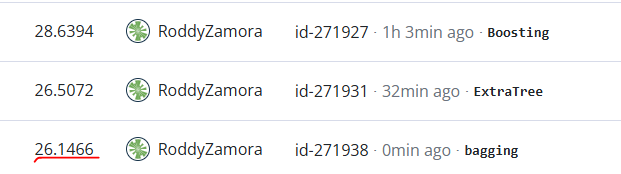

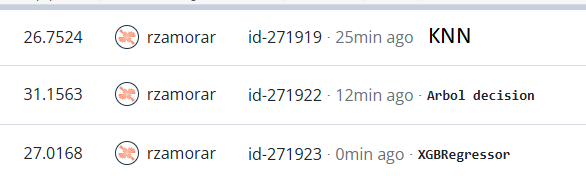

Gracias profesor por sus enseñanzas y por su actitud a lo largo de esta materia.